In [2]:
import os
import re
import time
import pandas as pd
import numpy as np
from google.cloud import language_v1

In [3]:
df = pd.read_csv("spongemania-transcripts.csv")

In [4]:
df.head()

,web-scraper-order,web-scraper-start-url,episode-link,episode-link-href,episode-text
0,1612452997-189,https://www.sbmania.net/transcripts.php,No Nose Knows,https://www.sbmania.net/transcripts.php?id=235,(Squidward walks into his house and puts down ...
1,1612452669-41,https://www.sbmania.net/transcripts.php,Kenny the Cat,https://www.sbmania.net/transcripts.php?id=454,"(The scene begins in the Krusty Krab, Squidwar..."
2,1612452939-163,https://www.sbmania.net/transcripts.php,Sand Castles in the Sand,https://www.sbmania.net/transcripts.php?id=267,(SpongeBob comes out of his pineapple and knoc...
3,1612452660-37,https://www.sbmania.net/transcripts.php,Tutor Sauce,https://www.sbmania.net/transcripts.php?id=461,(Opening at the Krusty Krab)\n\nMr. Krabs: And...
4,1612452698-54,https://www.sbmania.net/transcripts.php,License to Milkshake,https://www.sbmania.net/transcripts.php?id=435,(SpongeBob is flipping Krabby Patties. He is g...


In [5]:
df = df.drop(columns= ['web-scraper-start-url', 'episode-link-href', 'web-scraper-order'])

In [6]:
df.head()

,episode-link,episode-text
0,No Nose Knows,(Squidward walks into his house and puts down ...
1,Kenny the Cat,"(The scene begins in the Krusty Krab, Squidwar..."
2,Sand Castles in the Sand,(SpongeBob comes out of his pineapple and knoc...
3,Tutor Sauce,(Opening at the Krusty Krab)\n\nMr. Krabs: And...
4,License to Milkshake,(SpongeBob is flipping Krabby Patties. He is g...


In [7]:
df = df.rename(columns = {'episode-link': 'episode', 'episode-text':'full_transcript'})

In [8]:
df.head()

,episode,full_transcript
0,No Nose Knows,(Squidward walks into his house and puts down ...
1,Kenny the Cat,"(The scene begins in the Krusty Krab, Squidwar..."
2,Sand Castles in the Sand,(SpongeBob comes out of his pineapple and knoc...
3,Tutor Sauce,(Opening at the Krusty Krab)\n\nMr. Krabs: And...
4,License to Milkshake,(SpongeBob is flipping Krabby Patties. He is g...


In [111]:
p = re.compile(r"(?P<character>\w[^:\s]*):[\s\S](?P<line>.*)")

In [131]:
df_list = []

def create_dialogue_df(raw_dialogue):
    global df_list
    try:
        reg_list = p.findall(raw_dialogue)
        df = pd.DataFrame(reg_list, columns = ['character', 'line'])
        df_list.append(df)
    except:
        df_list.append(pd.DataFrame([]))

In [132]:
df.full_transcript.apply(lambda x: create_dialogue_df(x))

0      None
1      None
2      None
3      None
4      None
       ... 
393    None
394    None
395    None
396    None
397    None
Name: full_transcript, Length: 398, dtype: object

In [133]:
create_dialogue_df(df.full_transcript[0])

In [134]:
df_list

[    character                                               line
 0   Squidward  I thought I told that kid not to put the organ...
 1   SpongeBob  What about Patrick? Does he have to find his o...
 2   Squidward  (sighs) What are you taking about, nitwit? He ...
 3     Patrick  Of course I have a nose, Squidward. Why, it's ...
 4   Squidward  My floors! Think fast, Squiddy. I've got your ...
 ..        ...                                                ...
 70  SpongeBob  Yes, sir! (knocks on Patrick's rock and runs a...
 71    Patrick  Hello. (sniffs the odor which, in turn, causes...
 72  SpongeBob  (reading tombstone) Here lies the nose of Patr...
 73  Squidward  Who cares? At least now that pink moron will l...
 74    Patrick         I heard that! (Patrick has giant ears now)
 
 [75 rows x 2 columns],
     character                                               line
 0   Squidward  SpongeBob how about more Krabby Patties and le...
 1   SpongeBob  Wow, that's the longest I've held 

In [135]:
merged_list = pd.concat(df_list)

In [136]:
merged_list

,character,line
0,Squidward,I thought I told that kid not to put the organ...
1,SpongeBob,What about Patrick? Does he have to find his o...
2,Squidward,"(sighs) What are you taking about, nitwit? He ..."
3,Patrick,"Of course I have a nose, Squidward. Why, it's ..."
4,Squidward,"My floors! Think fast, Squiddy. I've got your ..."
...,...,...
70,SpongeBob,"Yes, sir! (knocks on Patrick's rock and runs a..."
71,Patrick,"Hello. (sniffs the odor which, in turn, causes..."
72,SpongeBob,(reading tombstone) Here lies the nose of Patr...
73,Squidward,Who cares? At least now that pink moron will l...


In [137]:
merged_list.to_csv("full_sponge_dialogue.csv")

In [139]:
merged_list.dropna()

,character,line
0,Squidward,I thought I told that kid not to put the organ...
1,SpongeBob,What about Patrick? Does he have to find his o...
2,Squidward,"(sighs) What are you taking about, nitwit? He ..."
3,Patrick,"Of course I have a nose, Squidward. Why, it's ..."
4,Squidward,"My floors! Think fast, Squiddy. I've got your ..."
...,...,...
70,SpongeBob,"Yes, sir! (knocks on Patrick's rock and runs a..."
71,Patrick,"Hello. (sniffs the odor which, in turn, causes..."
72,SpongeBob,(reading tombstone) Here lies the nose of Patr...
73,Squidward,Who cares? At least now that pink moron will l...


In [140]:
def analyze_sentiment(text):
    client = language_v1.LanguageServiceClient()
    document = language_v1.Document(content=text, type_=language_v1.Document.Type.PLAIN_TEXT)
    sentiment = client.analyze_sentiment(request={'document': document}).document_sentiment
    print("Text: {}".format(text))
    print("Sentiment: {}, {}".format(sentiment.score, sentiment.magnitude))
    return [sentiment.score, sentiment.magnitude]

In [143]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=r"C:\Users\mazon\jupyter-projects\personal-302809-c46a155d3fdf.json"

In [145]:
for x in range(len(df_list)):
    df_list[x] = df_list[x][df_list[x]['character'] == 'Squidward']

In [148]:
for df in df_list:
    df['sentiment'] = df['line'].apply(lambda x: analyze_sentiment(x))
    time.sleep(60)

Text: I thought I told that kid not to put the organic sea cucumber on top of the free-range anemones. (sighs) At least my flowers survived the trip. (inhales deeply. Then SpongeBob's nose is inhaled in his nostril. Squidward screams and sneezes SpongeBob across the room) SpongeBob, would you please find your own flowers to sniff?
Sentiment: -0.20000000298023224, 1.100000023841858
Text: (sighs) What are you taking about, nitwit? He doesn't even have a nose.
Sentiment: -0.10000000149011612, 0.30000001192092896
Text: My floors! Think fast, Squiddy. I've got your nose.
Sentiment: 0.10000000149011612, 1.2999999523162842
Text: Yeah I've got it right here. (Squidward pretends to grab Patrick's invisible nose in his hand)
Sentiment: 0.10000000149011612, 1.0
Text: If you want it, you gotta go get it. (pretends to throw the nose out the door. SpongeBob and Patrick run after it as Squidward shuts the door)
Sentiment: 0.0, 1.600000023841858
Text: Let's see Patrick destroy these. (Patrick sniffs t

Text: Get out! (pushes SpongeBob out)
Sentiment: -0.4000000059604645, 0.800000011920929
Text: Take it, SpongeBob. Take it, please. And promise me, no matter how much I may beg, and plead, and cry, don't give that paper back to me...ever!
Sentiment: -0.4000000059604645, 1.2999999523162842
Text: (walking up to his clarinet) SpongeBob... (SpongeBob is laughing outside. Squidward tries to play his clarinet but Squidward gets annoyed by SpongeBob's laughter so he peeks out the window) What in the world are you giggling about?
Sentiment: -0.10000000149011612, 0.6000000238418579
Text: How can anyone have fun with just a piece of paper? (Squidward plays his clarinet but has to stop due to SpongeBob's laughter continuing) Ohh...what can he possibly be doing with that paper?! (peeks out his window and SpongeBob is running around with the piece of paper high, above his head)
Sentiment: -0.4000000059604645, 1.2999999523162842
Text: Super-moron's more like it.
Sentiment: -0.10000000149011612, 0.100

Text: Let me out of here.
Sentiment: -0.800000011920929, 0.800000011920929
Text: I gotta get out of here. (tries to climb out of the well)
Sentiment: -0.4000000059604645, 0.8999999761581421
Text: There's not way to climb out of here.
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: Well, why don't I just start right now? Afterall, I got a couple of dumbbells right here. (laughs)
Sentiment: 0.10000000149011612, 1.2000000476837158
Text: Could you not stand so close? You're making me claustrophobic.
Sentiment: -0.5, 1.100000023841858
Text: No, it doesn't.
Sentiment: -0.699999988079071, 0.699999988079071
Text: It's not working, Patrick.
Sentiment: -0.800000011920929, 0.800000011920929
Text: Oh, sorry, Spongebob.
Sentiment: -0.6000000238418579, 0.6000000238418579
Text: Eww. Patrick!
Sentiment: 0.4000000059604645, 0.800000011920929
Text: (shoves Patrick) Stop pushing me, Patrick.
Sentiment: -0.5, 0.5
Text: No, like this! (shoves Patrick)
Sentiment: 0.0, 0.20000000298023224
Text: Pa

Text: And your name is... Susie Fish, correct?
Sentiment: 0.0, 0.0
Text: Mr Krabs! That's the last customer. Do I win?
Sentiment: 0.0, 1.0
Text: Uh, that's, that's...
Sentiment: -0.20000000298023224, 0.20000000298023224
Text: (shoves Spongebob) Out of the way, loser. (runs over to the customer)
Sentiment: -0.5, 1.100000023841858
Text: Um, hello. My name is Squidward. (customer looks at him with an annoyed face) Uh, so, what's your name?
Sentiment: -0.10000000149011612, 1.0
Text: Uh, it's just that I was going to...enter your name in our sweepstakes! (takes out paper and pen)
Sentiment: 0.0, 0.699999988079071
Text: So, what should I put down?
Sentiment: 0.0, 0.0
Text: Sure.
Sentiment: 0.20000000298023224, 0.20000000298023224
Text: I see he wants to play hard to get. So be it! I have ways of making the likes of him talk. Uh, sir, you forgot your soda.
Sentiment: 0.0, 1.899999976158142
Text: It's on the house. (throws the soda in the customer's face)
Sentiment: -0.10000000149011612, 0.400

Text: This place is amazing!
Sentiment: 0.8999999761581421, 0.8999999761581421
Text: Looks like I'll be inspiring these Atlantean artmakers with my beauty! You guys go on ahead!
Sentiment: 0.800000011920929, 1.7000000476837158
Text: I'm never leaving this place! I've learned more on painting in a few hours here than I did four years of community college.
Sentiment: 0.800000011920929, 1.600000023841858
Text: (Leaning through the order window.) SpongeBob, one extra large order of sea fries.
Sentiment: 0.0, 0.10000000149011612
Text: (Pauses.) Please.
Sentiment: -0.10000000149011612, 0.30000001192092896
Text: Yes. Yes, it was.
Sentiment: 0.20000000298023224, 0.5
Text: One large sea fries … extra weird.
Sentiment: 0.0, 0.0
Text: Spongebob?
Sentiment: 0.0, 0.0
Text: Spongebob?
Sentiment: 0.0, 0.0
Text: Spongebob, look!! (picks him up and turns him around where we are shown a tall building)
Sentiment: 0.20000000298023224, 0.800000011920929
Text: why would anyone stay in a hotel in Bikini Bott

Text: Look!!! (He points to outside, where a solid gold limosine pulls up to the Krusty Krab. Everyone gasps, then runs out to the limo, knocking over and walking over SpongeBob. When SpongeBob lifts his head, to his great disappointement, he sees his burger is trampled with a big footprint in the middle.) Awww...
Sentiment: 0.10000000149011612, 2.200000047683716
Text: Good ol' Jim! When you worked here, the place had class.
Sentiment: 0.6000000238418579, 1.2999999523162842
Text: No.
Sentiment: -0.6000000238418579, 0.6000000238418579
Text: Now I feel complete!
Sentiment: 0.8999999761581421, 0.8999999761581421
Text: SpongeBob, what are you doing in there?
Sentiment: -0.20000000298023224, 0.20000000298023224
Text: Well, hurry it up. I gotta cry, too.
Sentiment: -0.10000000149011612, 0.30000001192092896
Text: Because when Jim leaves, I'll be stuck with you again!
Sentiment: 0.30000001192092896, 0.30000001192092896
Text: Really? (Mexican Feista music starts to play.) Yes! Ha, cha-cha! Ha, 

Text: Observe a true master at work. (classical music plays as Squidward plies')
Sentiment: 0.5, 1.0
Text: Oh, baby, I knew it. You won't be sorry you've made this decision.
Sentiment: 0.10000000149011612, 0.30000001192092896
Text: Squ...Squ...Squ...Squ...Squ...Squ...Squ... Wah?
Sentiment: 0.0, 0.10000000149011612
Text: SpongeBob, remember that little talk we had about 'personal space'? 
Sentiment: -0.20000000298023224, 0.20000000298023224
Text: Co-Cashier? 
Sentiment: 0.0, 0.0
Text: You can't do this to me! If you think I'm going to stand out there all day listening to "Blah, blah, blah, blah, blah, blah, blah, blah, blah, blah, blah, blah..." then you must have coral wedged in your frontal lobe! 
Sentiment: -0.699999988079071, 1.5
Text: I'd like my view to be a little less yellow, if you know what I mean. 
Sentiment: -0.20000000298023224, 0.20000000298023224
Text: SpongeBob, have you finished swabbing the deck?
Sentiment: 0.0, 0.0
Text: You don't know how lucky you are.
Sentiment: 0.

Text: (signs) Ok, now what is this?
Sentiment: -0.4000000059604645, 0.4000000059604645
Text: Oh, of course. I've got head shots, you know. (shows pictures of himself then drops them and hits himself) What the...
Sentiment: -0.10000000149011612, 0.6000000238418579
Text: What's happening? (Spongebob and Patrick are fighting over the controls which causes them to keep crashing into Squidward's nervous system)
Sentiment: -0.6000000238418579, 1.2999999523162842
Text: (punches self) You think?
Sentiment: -0.20000000298023224, 0.20000000298023224
Text: Oh, I'm sorry. I'm not in control of my actions. (Spongebob and Patrick bounce off Squidward's nervous system)
Sentiment: -0.6000000238418579, 1.899999976158142
Text: Stop burping inside me! That's disgusting!
Sentiment: -0.800000011920929, 1.7000000476837158
Text: What?
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: What?
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: Morons. (the submarine crashes into Squidward's thro

Text: Alright, you two, I am trying to have a relaxing evening. What in the world are you doing out here?
Sentiment: 0.10000000149011612, 0.5
Text: You're playing Flashlight Tag with an electric eel?
Sentiment: -0.30000001192092896, 0.30000001192092896
Text: Advanced rul-- (growls) That has got to be the most ridiculous thing I have ever-- (Patrick stings him with the eel. Screams screams and then gets an allergic reaction on his arm)
Sentiment: -0.699999988079071, 1.399999976158142
Text: (in the fetal position under a chair) All I want to do is live in a world where I can just relax in peace and quiet. (sniffs) is that to much to ask?
Sentiment: 0.0, 0.6000000238418579
Text: (still crying) All I want to do is live in a world where I can live in peace. (sobs) Is that too much to ask?
Sentiment: -0.10000000149011612, 0.30000001192092896
Text: All I really want is to live in the world where I can just relax... (sniffs) in peace.
Sentiment: 0.10000000149011612, 0.10000000149011612
Text: (

Text: Now, do you two have anything to say for yourselves?
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: No, no, no, no, no, no!!! Sshhhh!!!
Sentiment: -0.10000000149011612, 1.2000000476837158
Text: No, no, no, no, no, no!!! They said, "Squilliam"!
Sentiment: -0.30000001192092896, 0.8999999761581421
Text: No! Wait! No!
Sentiment: -0.5, 1.5
Text: You're not going anywhere!
Sentiment: 0.800000011920929, 0.800000011920929
Text: What's going on here?
Sentiment: -0.5, 0.5
Text: But...
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: No, I don't! (retreats into his house)
Sentiment: -0.30000001192092896, 0.699999988079071
Text: Would you please get your friend out of my house?
Sentiment: 0.0, 0.0
Text: Where is he?
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: There he is! He's headed straight for my glass menagerie!
Sentiment: 0.30000001192092896, 0.699999988079071
Text: Phew...
Sentiment: 0.10000000149011612, 0.10000000149011612
Text: Of course.
Sentimen

Text: Ah, ah. Wait, wait. Let me help. Let's start with the circle again.
Sentiment: -0.20000000298023224, 1.100000023841858
Text: Huh? But, but, what about the head...and the erasing, and the, the...
Sentiment: -0.30000001192092896, 0.699999988079071
Text: Uhh... (crumples paper) How about this, huh? Remember?
Sentiment: -0.20000000298023224, 0.6000000238418579
Text: Forget about the book. (rips book) Ha! Look at all this mess Spongebob. What do all these little pieces of paper make you want to do.
Sentiment: -0.20000000298023224, 1.7000000476837158
Text: Ok, Spongebob. Let's just move onto the marble.
Sentiment: 0.30000001192092896, 0.6000000238418579
Text: Now you've got it.
Sentiment: 0.4000000059604645, 0.4000000059604645
Text: Right.
Sentiment: 0.30000001192092896, 0.30000001192092896
Text: Well, uh, ok.
Sentiment: 0.4000000059604645, 0.4000000059604645
Text: Uhh...
Sentiment: 0.10000000149011612, 0.10000000149011612
Text: Here you go, buddy.
Sentiment: 0.20000000298023224, 0.200

Text: I don't need zest! I need you out of my lampshade!
Sentiment: -0.4000000059604645, 0.8999999761581421
Text: Get out of there!
Sentiment: -0.699999988079071, 0.699999988079071
Text: Just get out of there!
Sentiment: -0.5, 0.5
Text: OK, that's enough! You've had your fun.
Sentiment: 0.5, 1.100000023841858
Text: Not the windows again!
Sentiment: -0.699999988079071, 0.699999988079071
Text: Gotcha! They're gone. Whew! Now if they'd just stay out of my house, I might be able to enjoy a little squid time.
Sentiment: 0.0, 1.7999999523162842
Text: I gotta get out of here!
Sentiment: -0.800000011920929, 0.800000011920929
Text: Go away!!! Can't you idiots take a hint!?!
Sentiment: -0.800000011920929, 1.600000023841858
Text: I think I lost 'em.
Sentiment: -0.6000000238418579, 0.6000000238418579
Text: How would you like it if someone did this to you!?!
Sentiment: -0.699999988079071, 0.699999988079071
Text: Why don't you... I do?
Sentiment: 0.0, 0.20000000298023224
Text: Well, uh, heh... That 

Text: (chuckles nervously) Um... hi.
Sentiment: 0.20000000298023224, 0.20000000298023224
Text: And I thought this friendship would never pay off. (walks away)
Sentiment: -0.20000000298023224, 0.5
Text: He took off his pants.
Sentiment: -0.5, 0.5
Text: I'll give him eleven minutes. (walks away)
Sentiment: -0.30000001192092896, 0.6000000238418579
Text: Mr., do us all a favor. (hands SpongeBob his  square pants)
Sentiment: 0.0, 0.20000000298023224
Text: Okay, that's enough. (everyone else hugs SpongeBob and Squidward)
Sentiment: 0.0, 0.30000001192092896
Text: Can we please stop this? (everyone stops hugging)
Sentiment: -0.10000000149011612, 1.100000023841858
Text: To go home?
Sentiment: 0.0, 0.0
Text: Mr. Krabs, you pay me to stand behind this register and take orders and give change. But you could never pay me enough to act brotherly towards (points at SpongeBob) ...that guy. (SpongeBob is washing a table with a scrubber. He scrubs his face and gets it mixed around. He laughs)
Sentiment:

Text: Oh, my...
Sentiment: 0.20000000298023224, 0.20000000298023224
Text: Look, surf boy! Are you going to teach us how to surf, or are we just gonna stand here and stare at you all day?
Sentiment: 0.10000000149011612, 0.800000011920929
Text: What, you call that a lesson? We just stood here and watched you surf for two and a half hours!
Sentiment: -0.4000000059604645, 0.800000011920929
Text: I don't know about you two, but I'd like to get out of here at some point! And his idea of teaching us is...
Sentiment: 0.4000000059604645, 0.800000011920929
Text: Oh, wonderful.
Sentiment: 0.8999999761581421, 0.8999999761581421
Text: That's it!?! I just wanna go home!
Sentiment: 0.0, 0.30000001192092896
Text: Oh, thank you! Thank you, SpongeBob!
Sentiment: 0.8999999761581421, 1.899999976158142
Text: Well? Did you talk to him?
Sentiment: 0.0, 0.10000000149011612
Text: And...?
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: We're gonna be stuck here forever!
Sentiment: 0.20000000298023224

Text: They don't.
Sentiment: -0.6000000238418579, 0.6000000238418579
Text: (screams loudly with hair growing out of his head and wiggling) That's the Sash-Wringing... The-the Flash-Singing... The Fash... P-Pinging...
Sentiment: 0.0, 1.0
Text: At last, you understand; we're doomed.
Sentiment: -0.5, 0.5
Text: (the figure starts to approach the restaurant) SpongeBob, there are two problems with your theory. One: I hate you. And two: How can that be me, when I'm standing right here?! (the figure taps on the door, SpongeBob screams with his eyelashes extending and wiggling)
Sentiment: -0.5, 2.0
Text: SpongeBob, no matter what I've said, I've always sort of liked you!
Sentiment: 0.8999999761581421, 0.8999999761581421
Text: Huh? (they continue to babble in fear as the figure enters the light. It turns out to be a nerdy fish, the evil eyes were actually his nostrils)
Sentiment: -0.4000000059604645, 1.2000000476837158
Text: Wait, if that was you on the phone and you on the bus, then who was fli

Text: Isn't there anything on that isn't about boxes? (changes channel)
Sentiment: -0.20000000298023224, 0.5
Text: Heh-heh, I guess this is ok. I mean, it's not really about boxes. (two cardboard boxes are going at each other) I give up.
Sentiment: -0.30000001192092896, 1.0
Text: How are they doing that? That was the most realistic space launch I ever heard! There must be an explanation. Think, Squidward, think! (imagines of a tape recorder they hav and playing real effects)
Sentiment: 0.10000000149011612, 2.299999952316284
Text: Laugh at me, will they? (opens box) All right, where is it?
Sentiment: -0.10000000149011612, 0.30000001192092896
Text: Don't "Where's what, Squidward?" me! Where's the tape recorder?
Sentiment: -0.10000000149011612, 1.100000023841858
Text: Don't "We don't have a tape recorder, Squidward" me!
Sentiment: -0.30000001192092896, 0.30000001192092896
Text: All right, make way you two, I'm coming in. (gets into box)
Sentiment: 0.0, 0.10000000149011612
Text: Don't mind

Text: Uh-huh.
Sentiment: -0.20000000298023224, 0.20000000298023224
Text: (sigh) I know I'm gonna hate myself for saying this, (gets up) but… whadda you got?
Sentiment: -0.800000011920929, 0.800000011920929
Text: (bored) "O"?
Sentiment: 0.0, 0.0
Text: (draws X, passes pad)
Sentiment: 0.0, 0.0
Text: (draws X and a line, picks up pad bored) Tic-Tac.
Sentiment: 0.0, 0.0
Text: Tic… and… Tac!
Sentiment: 0.20000000298023224, 0.5
Text: (picks up longer rope)
Sentiment: 0.0, 0.0
Text: (exacerbated) I don't see the point of this game night. Every game that Patrick has (air quotes) "Invented" is more pointless and boring than the last.
Sentiment: -0.699999988079071, 1.5
Text: We haven't started and I'm already bored.
Sentiment: -0.800000011920929, 0.800000011920929
Text: (bored) Yeah… in crayon.
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: More like a lame-a-torium. Heh
Sentiment: 0.0, 0.800000011920929
Text: (yawns, sarcastically) Are we finished? (shrugs) Who won?
Sentiment: -0.40

Text: It only seemed to increase their appetite for wieners.
Sentiment: -0.30000001192092896, 0.30000001192092896
Text: Right. Something that would make Mr. Krabs' whole wiener thing blow right up in his face.
Sentiment: 0.20000000298023224, 0.4000000059604645
Text: Well, I guess I was wrong again. It can always get more humiliating. 
Sentiment: -0.699999988079071, 1.5
Text: Oh no, SpongeBob. What could he possibly want?
Sentiment: 0.0, 0.4000000059604645
Text: Ahh! Mr. Krabs! Mr. Krabs, before it's too late, I gotta tell you about...
Sentiment: 0.20000000298023224, 1.100000023841858
Text: No. (Mr. Krabs wink)
Sentiment: -0.30000001192092896, 0.6000000238418579
Text: You're terrible! A hydro-what? (both start laughing then Mr. Krabs hears a sound)
Sentiment: -0.4000000059604645, 0.800000011920929
Text: What?
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: Please, please, quiet! Is this any way to behave, hmmm?
Sentiment: 0.0, 0.5
Text: Could we show a little decency and form

Text: That's not what I meant!
Sentiment: -0.800000011920929, 0.800000011920929
Text: I'm Squidward. I'm your neighbor.
Sentiment: 0.0, 0.0
Text: (inside his bedroom) Squidward, if you had some hair, you'd be the most gorgeous creature in the sea! You've got looks, talent, all you need is a full head of… (the moustache lands on his head) hair!
Sentiment: 0.6000000238418579, 1.2999999523162842
Text: (wearing the moustache as a wig) I think I fancy a stroll around the park. 
Sentiment: 0.30000001192092896, 0.30000001192092896
Text: (coming out his front door) What do you want? (notices the dollar bill on the mat) Hello…what's this? Someone left me some money for a perm. (SpongeBob and Patrick giggle) Come to Hairy! (As Squidward reaches for the bill, SpongeBob yanks it away. Squidward falls on his face and the moustache wig flies off. SpongeBob and Patrick burst out laughing.) SpongeBob! Ooh, my hair! SpongeBob!!! (goes back inside and slams the door)
Sentiment: 0.0, 6.0
Text: Ooh! Ow, o

Text: A really good try. But let's see how you do against my machine set on high. (pulls down the machine lever to set it on high)
Sentiment: 0.0, 1.600000023841858
Text: Ha, ha.
Sentiment: 0.0, 0.0
Text: I got one last chance, I'll turn up the heat.
Sentiment: -0.30000001192092896, 0.30000001192092896
Text: (runs out of the Krusty Krab) Let me know if I won!
Sentiment: 0.10000000149011612, 0.10000000149011612
Text: Ah. (licks some more) Ah, delish. (brings a bowl of stew to the table) Oh, silly me. I forgot the napkin. (walks off to get it from the cabinet) And now an elegant meal for an elegant person. (walks back to the table to see Patrick eating his stew)
Sentiment: 0.10000000149011612, 3.0999999046325684
Text: What are you doing here?
Sentiment: -0.20000000298023224, 0.20000000298023224
Text: Patrick, you dimwitted moron, get out of my kitchen!
Sentiment: -0.8999999761581421, 0.8999999761581421
Text: Get this into your tiny, tiny, little, tiny brain-- this is not a resort. It's m

Text: Just where I always seem to be on a nice, sunny day.
Sentiment: 0.8999999761581421, 0.8999999761581421
Text: Worse how?
Sentiment: -0.800000011920929, 0.800000011920929
Text: Sick? Is that really even worse?
Sentiment: -0.4000000059604645, 0.8999999761581421
Text: Oh really?
Sentiment: -0.30000001192092896, 0.30000001192092896
Text: SpongeBob? Oh SpongeBob I'm suddenly not feeling very well. (He fakes a cough.)
Sentiment: -0.4000000059604645, 1.399999976158142
Text: Well uh, let's see uh.... I have a scratchy throat... uh... in my mouth and um uh... my eyes are itchy. (He scratches them.) 
Sentiment: -0.4000000059604645, 1.899999976158142
Text: I'm not sure, but I fear I might be coming down with a dreaded illness.
Sentiment: -0.699999988079071, 0.699999988079071
Text: The name? Oh um... Squa... Squi... Squer... Squeer... uh, Squid's Disease.
Sentiment: 0.0, 1.0
Text: Squid's Disease.
Sentiment: -0.20000000298023224, 0.20000000298023224
Text: SpongeBob? SpongeBob. (SpongeBob hide

Text: Jammed again. (reaches inside to fix it but pokes Spongebob)
Sentiment: -0.20000000298023224, 0.5
Text: Spongebob? What are you doing here?
Sentiment: 0.0, 0.20000000298023224
Text: In the dishwasher?
Sentiment: 0.0, 0.0
Text: Spongebob living at the Krusty Krab? Wait a minute, if he's living here, that means he won't be living next to me. Oh. (imagines falling in a pile of flowers but it's really pots and pans. Mr Krabs is seeing Squidward making an angel on the floor)
Sentiment: 0.0, 1.5
Text: Just saying goodnight to Spongebob, Mr Krabs. Sweet dreams, Spongebob. You look much more comfier in here than in your old home.
Sentiment: 0.30000001192092896, 1.5
Text: (laughing) No. Coming Eugene. (cheers as he walks out the Krusty Krab) Good night's sleep, here I come. (cut to next day where Squidward is talking to a customer) And when I went home at night, guess what?
Sentiment: 0.0, 1.899999976158142
Text: Right! And when I woke up in the morning...
Sentiment: 0.20000000298023224, 

Text: A log cabin?
Sentiment: 0.0, 0.0
Text: Everyone's a critic.
Sentiment: -0.30000001192092896, 0.30000001192092896
Text: Oh, good-bye paint brush, hello antique fitting. Well, that ought to keep them busy for a while. (cut to later, Spongebob and Patrick are taking apart the arch on the side of the Krusty Krab)
Sentiment: 0.0, 1.2999999523162842
Text: That, I sculpted out the concrete foundation of the Chum Bucket.
Sentiment: 0.0, 0.0
Text: Those were all fabrocated from the Chum Bucket walls.
Sentiment: -0.30000001192092896, 0.30000001192092896
Text: Oh, that's Plankton's wife.
Sentiment: 0.0, 0.0
Text: Please tell me this isn't a joke.
Sentiment: -0.5, 0.5
Text: (He takes Perch's microphone.) Hello out there Bikini Bottom, I'm glad I can finally talk to my adoring fans on television.
Sentiment: 0.4000000059604645, 1.100000023841858
Text: Those dimwits don't stand a chance against my imported worm. (The sleigh comes to a stop and the British worm appears to have stopped for a fanc

Text: Morons.
Sentiment: 0.20000000298023224, 0.20000000298023224
Text: Just pick one! And there's another three where that came from!
Sentiment: 0.6000000238418579, 1.2999999523162842
Text: The suspense is killing me.
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: Magic. (Picks up boat and walks away)
Sentiment: 0.4000000059604645, 0.800000011920929
Text: (Fixing boat) Idiots wrecking my boat …
Sentiment: -0.5, 0.5
Text: So, who won your stupid quiz?
Sentiment: -0.800000011920929, 0.800000011920929
Text: (Snatches magazine) Let me see that. (Reads answers) A triangle? (Laughs) Patrick didn't know anything about you! And he's supposed to be your best friend?
Sentiment: -0.30000001192092896, 1.2000000476837158
Text: Looks like your best friend isn't a friend at all. (Laughs)
Sentiment: -0.30000001192092896, 0.8999999761581421
Text: Squidward, my man, you are perfect! (walksoutside to the back of his house) Oh no! My kelp garden is all wilted! Don't worry fellas, I've got jus

Text: (miserably) I just can't seem to get happy. (opens oven, puts head in it, takes out a tray of burnt brownies) Well, that didn't help. (phone rings) Huh!? That's strange, I swear I just threw that darn phone away. (sees fax machine) Oh yeah, my fax machine, now, why did I buy that? (scratches head)
Sentiment: -0.5, 3.299999952316284
Text: Yes. (puts him in a paper shredder and SB shreds, picks box of shreds up) Thanks for stopping by. (pours shreds out window) 
Sentiment: 0.20000000298023224, 1.2000000476837158
Text: (picks up a rope, miserably) I just can't seem to get happy. (hangs rope) Maybe this will help. (pulls to see a bird cage, scallop tweets, he grins, scallop spits purple goo on him and knocks him down, flies away, with cage on head) No, I guess not. (hears a knock) Oh, great, I wonder who that could be. (looks in mail slot to see mailman) You're not SpongeBob.
Sentiment: -0.20000000298023224, 2.700000047683716
Text: Tentacles, yes that's me.
Sentiment: 0.2000000029802

Text: SpongeBob, will you forget the stupid pioneers? Have you ever noticed that there are none of them left? That's because they were lousy hitchhikers, ate coral and took directions from algae! And now, you're telling me they thought they could drive... (SpongeBob runs over Squidward with the boulder) ...rocks? Hold on there, Jethro.
Sentiment: -0.4000000059604645, 2.799999952316284
Text: Sponge? Sponge? It's okay. Sponge? (SpongeBob starts crying like a baby) Sponge? (Squidward gets angry and takes a try at the customer)
Sentiment: -0.10000000149011612, 1.2999999523162842
Text: Well, this one's on the house! (throws pizza in face of Tom)
Sentiment: 0.10000000149011612, 0.10000000149011612
Text: He sure did. Ate the whole thing in one bite.
Sentiment: 0.30000001192092896, 0.699999988079071
Text: Nah. Now take me home (jumps up on the rock)
Sentiment: 0.10000000149011612, 0.6000000238418579
Text: Work? Oh, my aching tentacles!
Sentiment: 0.0, 0.10000000149011612
Text: No! And I want y

Text: (bangs his broom and jumps up and down on the floor) Keep it down! I'm trying to sleep! (people are partying outside the house, too)
Sentiment: 0.10000000149011612, 0.699999988079071
Text: Oh, no. It's that little yellow freak.
Sentiment: -0.5, 1.0
Text: Just ignore him. Maybe he'll go away.
Sentiment: -0.800000011920929, 1.600000023841858
Text: Do I know you?
Sentiment: 0.0, 0.0
Text: Never seen you before in my life.
Sentiment: 0.0, 0.0
Text: Is that supposed to be you? (SpongeBob sighs and walks away) I can't believe. He actually left. (laughs)
Sentiment: 0.0, 1.7000000476837158
Text: Being too darn happy all the time!
Sentiment: 0.8999999761581421, 0.8999999761581421
Text: (chuckles) Moron.
Sentiment: 0.0, 0.0
Text: Whatever.
Sentiment: 0.0, 0.0
Text: Oh, I'd love to.
Sentiment: 0.8999999761581421, 0.8999999761581421
Text: But...no! Don't... (gets dragged into the kitchen)
Sentiment: -0.699999988079071, 1.399999976158142
Text: (groans) Fine. Take a Krabby Patty and put it on 

Text: Too loose, Lautrec. (rim shot)
Sentiment: -0.4000000059604645, 0.8999999761581421
Text: Perfect. Hmmm, I feel needy. (claps his hands) Slaves, fetcheth me some nourishment.
Sentiment: 0.20000000298023224, 1.2000000476837158
Text: Enough of that! I want something else to eat now. Something that's very difficult to find.
Sentiment: -0.20000000298023224, 1.399999976158142
Text: Cherry pie. (Patrick holds up a cherry pie) Where'd you get that?
Sentiment: 0.0, 0.10000000149011612
Text: Well go find it again! (Patrick goes searching for it) SpongeBob, get over here. Now spin around. (SpongeBob turns around) That's better. Now jog in place. (SpongeBob jogs in place) Now say flank stank. (SpongeBob says it) I think I'm beginning to like this. Stop. (SpongeBob stops) Now, play me an elaborate song with this! (gives SpongeBob a tissue)
Sentiment: 0.10000000149011612, 4.099999904632568
Text: Oh, my. Always having to have it our way, don't we? Oh, boo-hoo. (SpongeBob tries to get the tissue 

Text: I'm not... (Spongebob tears off his face) ...wearing a disguise.
Sentiment: -0.4000000059604645, 0.8999999761581421
Text: (Takes Krabby Patty to customer) Here. (Drops Krabby Patty with plate on table)
Sentiment: 0.0, 0.10000000149011612
Text: Didn't see it, don't care.
Sentiment: -0.699999988079071, 0.699999988079071
Text: (The perspective switches to Squidward's house where it is morning and a clam yells like a rooster, he wakes up, but he has an expression that looks like something is off) Huh, how strange, usually I wake up each morning with a dark feeling of dread knowing at my stomach, but today I feel positively (Zooms in on Squidward's lips) happy. (He starts smiling, the perspective switches to a road where a smiling rainbow is over him, the sun is smiling, and he looks joyful) ♪Smiling rainbows!   Smiling sun! Smiling rocks, and vegetation! (The rocks and coral appear to have smiling faces and are rocking back and forth to the beat) Look ma I'm dancing, (Jumps up) and h

Text: And what did he say?
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: I… I can't believe you did that! (Smacks head)
Sentiment: 0.10000000149011612, 0.5
Text: (His house completely crumbles) Ow! Ach du lieber...
Sentiment: 0.20000000298023224, 0.20000000298023224
Text: The concert is ruined. My reed is shot. (shows it) See? I'm finished.
Sentiment: -0.30000001192092896, 1.2000000476837158
Text: (sobbing) But my reed! (Spongebob pulls one of his front teeth out and uses it as a reed)
Sentiment: 0.0, 0.30000001192092896
Text: But... (Spongebob slaps him)
Sentiment: 0.0, 0.20000000298023224
Text: Not bad. (Spongebob slaps him again)
Sentiment: 0.20000000298023224, 0.5
Text: And, I hate to admit it, but I suppose if you hadn't fixed my reed, the concert would have been a bust.
Sentiment: -0.699999988079071, 0.699999988079071
Text: How long do we have to keep this up?
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: Spongebob, I'm...
Sentiment: 0.0, 0.0
Text: Not r

Text: Ripping good day for a spot of driving.
Sentiment: 0.8999999761581421, 0.8999999761581421
Text: Hey, use your mirrors, fool!
Sentiment: -0.8999999761581421, 0.8999999761581421
Text: Ah! Can't see! D'oh! (puts on sunglasses and giggles. Screams as he crashes into a brick wall. Footage from crash test dummies is showing with Squidward's head replacing the dummie's head) Ow.
Sentiment: -0.10000000149011612, 2.4000000953674316
Text: Three patties, four large oyster skins, on the double, SpongeBob! (SpongeBob is still wearing his karate gear)
Sentiment: 0.10000000149011612, 0.6000000238418579
Text: SpongeBob!
Sentiment: 0.5, 0.5
Text: I'm going to pretend that didn't happen. (throws two pieces of paper at SpongeBob) Now fill these orders or leave, SpongeBob. We're very busy today! (SpongeBob runs out of the kitchen with tray of patties in his hands)
Sentiment: -0.20000000298023224, 1.5
Text: SpongeBob! Now are you gonna... (SpongeBob throws the tray backwards at Squidward causing the 

Text: Nice try tiny cyclops. You won't get Grandma's delicate mix of seasons and spices that easily. But operation can not be rushed. Each batch must sizzle for exactly twenty four hours.
Sentiment: -0.10000000149011612, 1.600000023841858
Text: Oh just taste it already.
Sentiment: 0.5, 0.5
Text: A star.
Sentiment: 0.0, 0.0
Text: Actually I can't share the recipe with you it's a secret. 
Sentiment: -0.20000000298023224, 0.20000000298023224
Text: Give that back please. Thank you.
Sentiment: 0.0, 1.5
Text: Anything for my fans. 
Sentiment: 0.8999999761581421, 0.8999999761581421
Text: What seems to be the problem? (He looks at Krabs and SpongeBob.) Well, well well. (He takes a fan and it blows away their fake facial hair.) If it isn't Mr. Krabs and SpongeBob. Now just follow me, I believe I have a table reserved just for you.
Sentiment: 0.10000000149011612, 2.0999999046325684
Text: Bon appétit suckers. (laughs) 
Sentiment: 0.0, 1.600000023841858
Text: See you in two years. Hahahaha!
Sentim

Text: Ice sculptor? Any fool can sculpt in ice. It takes true genius to transform 400 pounds of raw krabby patties into a work of such majesty.
Sentiment: 0.0, 1.399999976158142
Text: Boys Who Cry? They're my favorite band. They charge just to show up. And if you want them to lip-sync, it'll run into real money.
Sentiment: 0.0, 2.0999999046325684
Text: Oh yeah, I know all their songs.
Sentiment: 0.800000011920929, 0.800000011920929
Text: Here she comes, Mr Krabs.
Sentiment: 0.0, 0.0
Text: It is dishwater. (friends cough out the punch)
Sentiment: 0.0, 0.20000000298023224
Text: Hello, ladies.
Sentiment: 0.10000000149011612, 0.10000000149011612
Text: Oh, yeah, that's great. I'll be here working while you do-- (screams. He sees a fortune teller fish in front of the Krusty Krab) Uh-huh. Um, I'm sorry, ma'am... (gulps) ...but we're closed. (the fish splutters and wheezes) I see you're hungry but... (she retches more spit out of her mouth) Uh-huh, but we really are closed. Um, thank you. Come

Text: I was until you called.
Sentiment: -0.4000000059604645, 0.4000000059604645
Text: Wait, why did you ask me if I was watching House Fancy?
Sentiment: -0.6000000238418579, 0.6000000238418579
Text: Who's that talking in the background?
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: Hey, that's no better than my house! (goes up, revealing that it is much larger than Squidward's house. Squidward's thumb deflates as the camera keeps going up showing Squilliam's large house. Squidward is annoyed. Cut to Squilliam inside his home)
Sentiment: -0.4000000059604645, 2.0
Text: (imitates Nicholas in an annoyed manner) It's simply glorious!
Sentiment: 0.699999988079071, 0.699999988079071
Text: Hello, my name is Squidward Tentacles, and my house is far fancier than that slob Squilliam's!
Sentiment: 0.20000000298023224, 0.20000000298023224
Text: Really!
Sentiment: 0.0, 0.0
Text: Two hours? But I haven't even got time to wash my hair. (screams after he notices a spill on the rug from hi

Text: Spongebob, no.
Sentiment: -0.4000000059604645, 0.4000000059604645
Text: (pushes Spongebob out his door) I'm not writing a letter to a figment of your imagination.
Sentiment: -0.800000011920929, 0.800000011920929
Text: Spongebob, how many times do I have to say it? I don't believe in Santa Claus!!
Sentiment: -0.4000000059604645, 0.8999999761581421
Text: My self-respect, my sanity, my lunch. (closes door)
Sentiment: 0.20000000298023224, 0.699999988079071
Text: (pokes his head out his window) Santa Claus is a big phony! Spongebob has got you all fooled.
Sentiment: -0.8999999761581421, 1.7999999523162842
Text: Those idiots are gonna be up all night while I get a full nights sleep. (tries to sleep but the singing outside wakes him up)
Sentiment: -0.4000000059604645, 0.8999999761581421
Text: (alarm goes off) Ahh, morning already? Oh, boy! (speaking in a megaphone) Merry Christmas! Ho, ho, ho! Merry Christmas. Wait. Oh, I see a great Christmas photo op. Could you move in a little? Say S

Text: Wait, wait. I know tensions are high. (everyone gets into a fight) There's a deposit on the equipment, people. (everyone uses their instruments as weapons) Settle down, please. (clock sounds at 10 and everyone stops fighting)
Sentiment: -0.4000000059604645, 2.4000000953674316
Text: Well, you did it. You took my one chance at happiness and crushed it. Crushed it into little tiny, bite-size pieces. I really had expected better of you people. I guess I'm a loser for that, too. Don't bother showing up tomorrow. I'll just tell them you all died in a marching accident. So, thanks, thanks for nothing.
Sentiment: -0.5, 4.900000095367432
Text: I knew this was going to happen. They're just going to have to find another band to play. I just hope that... (sees Squilliam) ...Squilliam doesn't find out! Squilliam!! Ah! What are you doing here?
Sentiment: 0.0, 1.7999999523162842
Text: Um, they couldn't come. They...died.
Sentiment: -0.699999988079071, 1.399999976158142
Text: AH! That would be m

Text: Oh, what's this? Hmm, haven't seen this before, oh yeah, mmm.
Sentiment: -0.10000000149011612, 1.0
Text: A what?
Sentiment: -0.20000000298023224, 0.20000000298023224
Text: How disappointing.
Sentiment: -0.699999988079071, 0.699999988079071
Text: SpongeBob, do you realize what this means?
Sentiment: -0.4000000059604645, 0.4000000059604645
Text: No! It means some bratty teenager's coming in here to tell us what to do. We can't have that! We have seniority, right?
Sentiment: -0.30000001192092896, 1.5
Text: So, we'll work together to protect our pathetic positions.
Sentiment: 0.0, 0.0
Text: Well, I like it so far.
Sentiment: 0.8999999761581421, 0.8999999761581421
Text: OK, this is it, SpongeBob! Now tell her how you really feel about that uniform.
Sentiment: 0.10000000149011612, 0.30000001192092896
Text: Fish... Paste.
Sentiment: 0.30000001192092896, 0.699999988079071
Text: Well, I didn't think it was possible, SpongeBob, but you look even more ridiculous than usual.
Sentiment: -0.69

Text: (planting flowers) No, I'm not. (walks inside)
Sentiment: -0.20000000298023224, 0.4000000059604645
Text: Just ignore them, Squidward and continue your power walk. Heel toe, heel toe, heel toe, heel toe.
Sentiment: -0.10000000149011612, 0.800000011920929
Text: opens his window What do you want, Spongebob?
Sentiment: -0.20000000298023224, 0.20000000298023224
Text: More like another nickel.
Sentiment: -0.4000000059604645, 0.4000000059604645
Text: It's not that funny.
Sentiment: -0.800000011920929, 0.800000011920929
Text: move over. (flicks Spongebob off his legs and into the kitchen)
Sentiment: -0.4000000059604645, 0.8999999761581421
Text: (brings food tray over to a customer) Here's your food. (Spongebob is laughing behind him) It's not that funny! (slams tray down) Please make it stop! (Spongebob is running into the kitchen then out of Mr Krabs office still laughing. Scene zooms into Squidward with a bunch of Spongebobs laughing around his head. Scene cuts to Squidward flipping th

Text: Great. Go be friends somewhere else.
Sentiment: 0.20000000298023224, 1.399999976158142
Text: NO! Out! (both walk out)
Sentiment: -0.5, 1.100000023841858
Text: Oh, my back!
Sentiment: 0.5, 0.5
Text: (contented sigh) What a day! (rides his bike up to the Krusty Krab. Squidward enters, backs up and gets his hat. SpongeBob enters and squishes Squidward with the door)
Sentiment: 0.0, 0.5
Text: (Still smiling) Not a problem SpongeBob. Not a problem at all!
Sentiment: 0.800000011920929, 1.600000023841858
Text: Good morning sir! Welcome to the Krusty Krab.
Sentiment: 0.4000000059604645, 0.8999999761581421
Text: One Krabby Patty coming up!
Sentiment: 0.30000001192092896, 0.30000001192092896
Text: Even better. I have a clarinet recital immediately after work today, so ain't nothing gonna ruin my day. (baby squirts milk onto the clarinet case)
Sentiment: 0.20000000298023224, 0.8999999761581421
Text: No need! See? Not a drop! (baby drools on his clarinet)
Sentiment: 0.0, 0.6000000238418579
T

Text: I'm afraid so. (Squidward takes off the rest of the costume) SpongeBob.
Sentiment: -0.4000000059604645, 0.8999999761581421
Text: You know I hate you, right.
Sentiment: -0.8999999761581421, 0.8999999761581421
Text: Well, I hate the smell of burning Krabby Patties even more. (Squidward kneels down) Please come back and be the fry cook again!
Sentiment: -0.10000000149011612, 1.5
Text: Hmm, not exactly my color.
Sentiment: -0.699999988079071, 0.699999988079071
Text: What's she blabbering about?
Sentiment: -0.20000000298023224, 0.20000000298023224
Text: And drowning. Don't forget drowning. (SpongeBob laughs, then turns to Squidward)
Sentiment: -0.30000001192092896, 1.2000000476837158
Text: Not on your life, sport. (SpongeBob falls flat on his face)
Sentiment: -0.5, 1.100000023841858
Text: How about this! Huh? (he spins five plates on sticks while balancing on one foot)
Sentiment: -0.4000000059604645, 0.800000011920929
Text: How long can she stay like that?
Sentiment: -0.20000000298023

Text: Mustard?
Sentiment: 0.0, 0.0
Text: (join arms and dance in a circle) Look at all the mustard flow,
Sentiment: 0.0, 0.0
Text: I think we better use our heads.
Sentiment: -0.30000001192092896, 0.30000001192092896
Text: The mummy!
Sentiment: 0.800000011920929, 0.800000011920929
Text: (wipes off nose) Stop- Don't you see? This old coot wants all the mustard for himself! Now uncork that mustard! (old fish growls and raises his fists) Oh, put your fists down, old man, I'm not gonna hurt ya! (old fish punches him in the face. He falls backwards)
Sentiment: -0.30000001192092896, 1.7999999523162842
Text: (gets up) Why, you... (attempts to punch the old fish but is punched first) I'm gonna- (is punched again, with his head spinning around, before being hit again)
Sentiment: -0.800000011920929, 0.800000011920929
Text: (avoids cracking ground, until a phone is revealed behind the cave wall) I'll get it. (picks up phone) Hello.
Sentiment: 0.0, 0.0
Text: Um... (Patrick puts a cork onto SpongeB

Text: What?
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: (takes decree) Give me that. A treaty, huh? Well, here's what I think of your treaty. (throws it away. Cut to inside Patrick's castle where Spongebob has the treaty stuck in his forehead)
Sentiment: -0.20000000298023224, 1.2999999523162842
Text: SpongeBob?
Sentiment: 0.0, 0.0
Text: This is idiotic.
Sentiment: -0.8999999761581421, 0.8999999761581421
Text: You got it, Mr Krabs. (dances)
Sentiment: 0.10000000149011612, 0.30000001192092896
Text: Brine soda, low-fast seaweed crisps, cool jazz. (eats a seaweed crisp) Mm, mm, Squidward you have done it. You have officially spoiled yourself rotten.
Sentiment: 0.0, 1.899999976158142
Text: Magic? Can you make yourself disappear, Spongebob?
Sentiment: 0.0, 0.20000000298023224
Text: (sighs) This can't possibly end soon.
Sentiment: 0.0, 0.0
Text: (steps onto the bus that just pulled up) I don't care where I'm going, just take me away from here. (bus drives off)
Sentiment: -0.300

Text: (Reading to customers) Listen to this--SpongeBob has names his spatula "Fifi." (Customers all laugh)
Sentiment: 0.10000000149011612, 1.2000000476837158
Text: Oh, oh, this is the best one yet. Get this. "If I hear the Bikini Bottom Municipal Anthem, I can't help but take off all my clothes and dance around in my underwear!" (Everyone laughs) Quiet, quiet, quiet. Watch this. (Pulls out radio and plays the anthem)
Sentiment: 0.5, 3.299999952316284
Text: (Scoffs) He'll get over it.
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: Oh boy, let me see one of those papers. Uh-huh, mm-hm. (Cover of paper shows sad photo of SpongeBob. Squidward laughs and tosses the paper on the ground. Fish glare at him) Taxi! (Waves. Taxi tires screech)
Sentiment: 0.0, 1.7999999523162842
Text: Yes, I am. (Drives leaves, tires squeal. Squidward coughs in the exhaust)
Sentiment: 0.0, 0.30000001192092896
Text: Morons. (At his front door)
Sentiment: 0.10000000149011612, 0.30000001192092896
Text: (c

Text: You left your TV on.
Sentiment: -0.4000000059604645, 0.4000000059604645
Text: Mr. Krabs, why do you have cameras watching us?
Sentiment: -0.699999988079071, 0.699999988079071
Text: Those are just sock garters, you idiot.
Sentiment: -0.8999999761581421, 0.8999999761581421
Text: This is not happening, it's just not happening. (Mr. Krabs takes the right path and the others take the left)
Sentiment: -0.10000000149011612, 1.5
Text: SpongeBob, if you had never come to Bikini Bottom, this wouldn't be happening.
Sentiment: -0.5, 0.5
Text: I was just... remembering the world before SpongeBob. (start flashback. Squidward gets out of bed happily and waters the ground. Pink flowers pop up)
Sentiment: 0.10000000149011612, 0.8999999761581421
Text: Good morning, not SpongeBob. (kisses the cook. Flashback ends)
Sentiment: 0.10000000149011612, 0.5
Text: My secret garden is finally done. (the giant pineapple falls on Squidward. He cuts out a door)
Sentiment: 0.10000000149011612, 0.800000011920929


Text: (running towards Plankton, still trying to fly) Gaining speed, increasing thrust, raising nose, air pressure on tentacles, stray tables in right position, and liftoff! (leaps into the air)
Sentiment: 0.0, 0.20000000298023224
Text: Uhh... (holds up his magazine over his face)
Sentiment: 0.10000000149011612, 0.10000000149011612
Text: Ten, nine, eight, seven, six, five, four, three, two, one. (looking at his watch while Spongebob is mopping the floor) I'm done with my shift, Mr Krabs! And let me just say, there will come a day when I will make something of my life and I will never have to set foot in this grease trap again! (a crowd of people stand up and cheer behind him)
Sentiment: -0.20000000298023224, 1.100000023841858
Text: Ok. (walks out)
Sentiment: 0.0, 0.0
Text: (gasps) Oh, shrimp! It's my arch rival from high school, Squilliam Fancyson! I can't let him see me in my Krusty Krab uniform. (takes off his hat and is about to put it in the trashcan)
Sentiment: 0.10000000149011612

Text: So, do it when you're done!
Sentiment: 0.30000001192092896, 0.30000001192092896
Text: Would you like to hear a secret?
Sentiment: 0.10000000149011612, 0.10000000149011612
Text: See that guy over there?
Sentiment: -0.20000000298023224, 0.20000000298023224
Text: He wants to be a fry cook, and you're his hero!
Sentiment: 0.4000000059604645, 0.4000000059604645
Text: Why don't you give him a couple of pointers. Let him cook his own patty, and don't take "no" for an answer. He's shy.
Sentiment: -0.6000000238418579, 2.0
Text: This should be good.
Sentiment: 0.6000000238418579, 0.6000000238418579
Text: Moron.
Sentiment: 0.20000000298023224, 0.20000000298023224
Text: Ha, ha! SpongeBob will believe anything!
Sentiment: 0.5, 1.0
Text: SpongeBob, what're you doing?
Sentiment: -0.30000001192092896, 0.30000001192092896
Text: You're serving Krabby Patties with your hands? Do you know how filthy your hands are?
Sentiment: -0.5, 1.100000023841858
Text: But your feet, however, are nice and clean! 

Text: What, you wanted a piece or art and that's what you got.
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: As long as you're wanting to sell this many patties. (Mr. Krabs groans)
Sentiment: 0.20000000298023224, 0.5
Text: I'm not much of a summer person, Spongebob.
Sentiment: -0.30000001192092896, 0.30000001192092896
Text: You mean this morning?
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: (The scene cuts to Squidward being inside a tub within his bathroom) Ahhh, the sanctity of my bathroom, the only place in the world where I can let it all hang out. (Squidward loosens his nose and his nose enlarges) Ahhh, me. (Squidward sits back and submerges himself in the bathtub, with only his head slightly sticking out, the point of view is shifted towards SpongeBob and Patrick's brains, now inside Squidward's bathroom)
Sentiment: -0.30000001192092896, 1.100000023841858
Text: (Squidward jumps up) Stop serenading me, you sap! It's my day off. Now, go away. (Squidward p

Text: (sarcastically) Oh, that's a good one.
Sentiment: -0.20000000298023224, 0.20000000298023224
Text: (laughs) Look at how betrayed Patrick feels! Oh, this was totally worth staying up all night.
Sentiment: 0.10000000149011612, 1.600000023841858
Text: (Patrick picks him up) Hey, come on! This is just a big misunderstanding! "Ferry". "Fairy". They're two different words that just happen to sound alike!
Sentiment: 0.0, 1.7999999523162842
Text: No! (Squidward's teeth scream, jump out of his mouth, and swim after the Tooth Ferry)
Sentiment: -0.4000000059604645, 0.800000011920929
Text: You're better off not knowing.
Sentiment: -0.699999988079071, 0.699999988079071
Text: Great, another hayseed.
Sentiment: 0.800000011920929, 0.800000011920929
Text: (sarcastically and drawn out) Right.
Sentiment: -0.699999988079071, 0.699999988079071
Text: Strange is right.
Sentiment: 0.20000000298023224, 0.20000000298023224
Text: Since when?
Sentiment: -0.20000000298023224, 0.20000000298023224
Text: Dead Ey

Text: Being dead, or anything else. 
Sentiment: -0.6000000238418579, 0.6000000238418579
Text: Where have you been? 
Sentiment: 0.10000000149011612, 0.10000000149011612
Text: Can I have one? 
Sentiment: 0.0, 0.0
Text: Spongebob, I don't need your help. I am ready to unlock my potential. I could be anything I set my mind to. (imagines himself as a football player) I could be a football player, or a king, or a spaceman. 
Sentiment: 0.0, 1.899999976158142
Text: Yeah...uh-huh. Ya know, that reminds me, there's been something I've been wanting to say to you since the day we met. < few a>Goodbye. Next time you see me, this town will be eating out of the palm of my hands. (skips to a homeless Squidward in a box trying to get spare change in a cup) Spare change? Spare change, ma'am? 
Sentiment: 0.0, 1.899999976158142
Text: Uh, I , uh...(closes his box) 
Sentiment: -0.4000000059604645, 0.4000000059604645
Text: Spongebob? 
Sentiment: 0.0, 0.0
Text: Yes? 
Sentiment: 0.20000000298023224, 0.20000000

Text: Well, I don't know how you did it, but thanks for getting rid of all that trash. They'll have that statue of me built in no time. (Walks into his house with his eyes closed and doesn't notice that everything is made of trash. Goes about his normal routine until suddenly, in bed, he sniffs and realizes that there's trash everywhere. He screams and runs outside.) My house!
Sentiment: 0.0, 3.0
Text: Yes?
Sentiment: 0.20000000298023224, 0.20000000298023224
Text: SpongeBob.
Sentiment: 0.20000000298023224, 0.20000000298023224
Text: What's this? (Points to the trash house)
Sentiment: -0.30000001192092896, 0.6000000238418579
Text: Where's my house?
Sentiment: -0.20000000298023224, 0.20000000298023224
Text: How?
Sentiment: 0.0, 0.0
Text: Of all the garbage that comes out of your mouth, this is the least annoying. (Laughs)
Sentiment: 0.4000000059604645, 0.8999999761581421
Text: Wait, wait! Zip it! I have an idea. (Gets a garbage can) Here, stand in this. (SpongeBob does so) See ya, sucker!

Text: Mediocre?
Sentiment: -0.699999988079071, 0.699999988079071
Text: What?
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: What's that supposed to mean? Some kind of stupid secret code? 
Sentiment: -0.4000000059604645, 0.800000011920929
Text: Oh yeah? What does it take to be a member? Besides being a moron... Hahaha...moron...as a requirement...hahaha... 
Sentiment: -0.20000000298023224, 1.399999976158142
Text: Well I'll have you know.. that I am a member of over 20 exclusive clubs all over the sea bottom.
Sentiment: -0.20000000298023224, 0.20000000298023224
Text: Oh what do two you zeros know about fitting in? 
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: Why...you should be begging me to join!!
Sentiment: -0.699999988079071, 0.699999988079071
Text: Well this is stupid.. there's no room up here!!
Sentiment: -0.6000000238418579, 1.2000000476837158
Text: (sneers)
Sentiment: 0.0, 0.0
Text: Shut your half-wit pieholes!! I do not now, nor will I ever, want to be 

Text: No.
Sentiment: -0.6000000238418579, 0.6000000238418579
Text: Ok, make it quick.
Sentiment: 0.0, 0.0
Text: Look, Spongebob, I was just... (Spongebob throws a snowball at Squidward but it lands in his fire again, putting it out) Spongebob! Oh... (picks up a snowball. Spongebob shrieks)
Sentiment: 0.0, 0.8999999761581421
Text: I most certainly am not!
Sentiment: -0.20000000298023224, 0.20000000298023224
Text: No Spongebob, I'm not on your side either. I'm on nobody's side. Snowball fights are for immature children and I will not stoop to your level. (drops the snowball) If you two want to knock each others brains out with snowballs, kindly leave me out of it. (walks back inside)
Sentiment: -0.5, 2.700000047683716
Text: Hmmm... (imagines Patrick throwing a snowball at Spongebob, knocking his brain out)
Sentiment: -0.5, 0.5
Text: (chuckles) Now there's something I'd actually like to see! (takes a chair up to one of his windows) Nothing wrong with getting a front row seat I suppose. (s

Text: Oooh, Krabsy.
Sentiment: 0.10000000149011612, 0.10000000149011612
Text: Just one more thing. I'm afraid you'll have to take over for me today.
Sentiment: -0.4000000059604645, 0.8999999761581421
Text: Oh, that's too bad. It looks my twisted ankle may become a permanent injury.
Sentiment: -0.699999988079071, 1.5
Text: Aah. (On Krusty Krab roof. Mr. Krabs comes up with tea) Oh Krabsy, after tea, I think a full tentacle massage would be in order.
Sentiment: 0.10000000149011612, 0.5
Text: (On phone) Hello, office worker safety department--
Sentiment: 0.0, 0.0
Text: Heh-hem. I'm waiting!
Sentiment: 0.10000000149011612, 0.30000001192092896
Text: Aaah. (Laying on Krusty Krab table getting a fry grease massage from Mr. Krabs. Moaning)
Sentiment: 0.10000000149011612, 1.100000023841858
Text: Oh, it's gonna be a long, slow recovery. Time to pop my back barnacles.
Sentiment: -0.5, 1.100000023841858
Text: (Sitting up on table with towel on) Oh, yes.
Sentiment: 0.30000001192092896, 0.3000000119

Text: (wipes off his foamy beard) It's me, you dunce!
Sentiment: 0.20000000298023224, 0.20000000298023224
Text: What's that supposed to mean? I'm very busy.
Sentiment: -0.10000000149011612, 0.20000000298023224
Text: I don't like your tone.
Sentiment: -0.8999999761581421, 0.8999999761581421
Text: Just do your jobs. (walks off)
Sentiment: -0.10000000149011612, 0.30000001192092896
Text: Must...rel... (breaks the chair) ...ax! (pulls out a mirror) Look at yourself. You're losing your bluish glow. Stop worrying so much! Now, repeat after me...you will not go back to the Krusty Krab. (his reflection turns into SpongeBob)
Sentiment: -0.30000001192092896, 1.899999976158142
Text: SpongeBob!!
Sentiment: 0.4000000059604645, 0.4000000059604645
Text: No! (walks out) That's it. That's it. No matter what sick fantasies run through my mind, I will not go back to that restaurant! (walks into his house then runs out towards the Krusty Krab)
Sentiment: -0.30000001192092896, 1.7000000476837158
Text: No, I

Text: Then bring that patty here now!
Sentiment: 0.0, 0.0
Text: Uhh, SpongeBob. I'm over here, now move!
Sentiment: 0.4000000059604645, 0.800000011920929
Text: SpongeBob! (the patty lands in his mouth)
Sentiment: 0.20000000298023224, 0.6000000238418579
Text: (chewing the patty) SpongeBob!
Sentiment: 0.20000000298023224, 0.20000000298023224
Text: Sponge... (patty enters his mouth)
Sentiment: 0.0, 0.20000000298023224
Text: I think my heart just stopped. (customers complain) It's Sponge... (burps) ...bob's fault! ('SpongeBob's fault' echoes in SpongeBob's head)
Sentiment: -0.5, 2.0
Text: It's SpongeBob's fault. (Mr. Krabs gets upset. His eyes turn into steamboat whistles)
Sentiment: -0.4000000059604645, 1.7000000476837158
Text: (growls. Grabs SpongeBob's lips) Would you stop that incessant babbling?
Sentiment: -0.30000001192092896, 0.800000011920929
Text: Would you quit it with that tune already?
Sentiment: -0.699999988079071, 0.699999988079071
Text: I don't care. Just can it. (walks back

Text: Thanks for the tip. I guess I'll just limp home, then.
Sentiment: 0.20000000298023224, 1.100000023841858
Text: Well, I guess I'll just have... (sea bear comes back and mauls Squidward again)
Sentiment: 0.0, 0.0
Text: What'd I do that time?
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: Ok. (sea bear comes back mauls Squidward again)
Sentiment: 0.10000000149011612, 0.10000000149011612
Text: Move over! (sea bear sees the circle, points at Squidward, then leaves) Hey, it worked! You guys saved my life.
Sentiment: 0.4000000059604645, 1.5
Text: What attracts them?
Sentiment: 0.0, 0.0
Text: Huh?
Sentiment: -0.30000001192092896, 0.30000001192092896
Text: Give me that! Stealing my mail, eh? You're lucky I don't report you to the authorities.
Sentiment: -0.4000000059604645, 1.5
Text: They're entrepreneurs, they sell things to people?
Sentiment: 0.0, 0.0
Text: How should I know? Things people want to buy. Now keep your paws off my mail. (walks off)
Sentiment: 0.1000000014901161

Text: Oh, that'll be the day! (he runs down the steps, SpongeBob blows his whistle at him and follows him)
Sentiment: 0.20000000298023224, 0.20000000298023224
Text: (runs to the kitchen, opens the fridge, and takes an armload of food out)
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: Oh, please. I just want to get back on my side of the boundary.
Sentiment: 0.0, 0.30000001192092896
Text: But all I wanted is something to eat.
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: My food!
Sentiment: 0.5, 0.5
Text: (looks at SpongeBob sadly) Is this really what we've come to? Is one little storm all it takes
Sentiment: -0.30000001192092896, 0.699999988079071
Text: Hey, did you hear that?
Sentiment: 0.0, 0.0
Text: No, no, no, no. Not that. I mean from outside.
Sentiment: -0.4000000059604645, 1.2999999523162842
Text: (starts running for the door) The storm must've stopped.
Sentiment: -0.6000000238418579, 0.6000000238418579
Text: (takes the boards off the front door) Woo-ho

Text: Aww! (Photographers and a jet-ski take pictures of the Squidward and the mirror)
Sentiment: 0.30000001192092896, 0.800000011920929
Text: Where is that idiot SpongeBob? Leaving me stuck with all the cooking. This job stinks! (sniffs the air) Ooh, literally. (looks behind him where there is SpongeBob's eyes floating in the air, looking at Squidward. He screams and runs into Mr. Krabs' office) Mr. Krabs! There's something in the kitchen you gotta see! (cut back to the lab)
Sentiment: -0.20000000298023224, 4.099999904632568
Text: See for yourself! Huh?
Sentiment: 0.10000000149011612, 1.100000023841858
Text: (screams) Mr. Krabs! There's a strange sound coming from the restroom! (cut back to Sandy)
Sentiment: -0.20000000298023224, 1.100000023841858
Text: I cannot believe I have to deliver all this junk food myself. (slips on a Krabby Patty and falls) What the...? (SpongeBob taps Squidward and hands him some new food trays) Oh, thank you. (SpongeBob's lower body is there but not his hea

Text: Whatever works.
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: Let's go SpongeBob, the orders are piling up.
Sentiment: -0.30000001192092896, 0.30000001192092896
Text: Come on SpongeBob chop chop.
Sentiment: -0.5, 0.5
Text: You deliver it I'm on break. 
Sentiment: -0.20000000298023224, 0.20000000298023224
Text: What is the hold up in here?
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: Face freeze? I thought that was a myth. Ha, Krabs too? Oho this is rich. Ahaha ho. Ahahaha! Wahaha! (His face freezes up too.) Hey my face. Aah my face! Oh great look at what you've done.
Sentiment: 0.0, 4.0
Text: Ahargha it's not funny. Stop laughing.
Sentiment: -0.10000000149011612, 1.399999976158142
Text: (in his kitchen, carrying a freshly-cooked brisket) La-da-dee, la-da-dum. la-da-doo. (He places the brisket next to a fancy meal proudly) Oh, it may have taken you all morning Squidward, but this is a meal fit for a king. (oven dings) Oh! My croque-madame is ready! (A te

Text: No, no no no no no no no! You morons would probably … (Thinks) You want to play with my lawnmower?
Sentiment: -0.6000000238418579, 1.7999999523162842
Text: (Vision ends; he gets excited and starts up the lawnmower) Knock yourselves out!
Sentiment: 0.5, 0.5
Text: I knew I shouldn't have lent them my lawnmower.
Sentiment: -0.4000000059604645, 0.4000000059604645
Text: He's a ghost, Mr. Krabs.
Sentiment: -0.6000000238418579, 0.6000000238418579
Text: Nothing ever happens in this dump.
Sentiment: -0.699999988079071, 0.699999988079071
Text: Why did I say that?
Sentiment: -0.5, 0.5
Text: Krusty Krab.
Sentiment: 0.20000000298023224, 0.20000000298023224
Text: (Bursts into the kitchen) What?! (SpongeBob runs around screaming until he is grabbed by Squidward) What are you screaming about?
Sentiment: -0.30000001192092896, 0.699999988079071
Text: Mr Krabs! 
Sentiment: 0.4000000059604645, 0.4000000059604645
Text: I'm on it. (Steps aside, letting the urchin in the dining room) 
Sentiment: 0.1000

Text: Because...I'm all out of money!!
Sentiment: -0.6000000238418579, 0.6000000238418579
Text: Very funny, Mr Krabs. If I can't win one of those stupid things with (this) quater, I'm walking away.
Sentiment: 0.0, 1.7000000476837158
Text: Huh?
Sentiment: -0.30000001192092896, 0.30000001192092896
Text: (scoots his way into his house and then sits on his couch) A little mind-numbing television ought to help me forget about that stupid machine. (tries to pick up the remote but everytime he tries, he fails. Uses his eye instead) Yeow!! (now in bed) You had a rough day, Squiddy. But that doesn't mean tomorrow won't be better. (tries to pull his covers but he can't) Ooh, phooey! (tries to pick up the glass of water by his bed but drops it and breaks it) I gotta win that crane! (runs through his closet door and gets the piggy bank. Later, Spongebob enters the krusty krab and freaks out at what he sees when he enters) Just once. Please, oh please, let me win one time.
Sentiment: -0.20000000298

Text: You will not get me to eat at the Chum Bucket, no matter how big the discount is.
Sentiment: -0.5, 0.5
Text: (Squidward starts watering Plankton) Shameless. 
Sentiment: 0.10000000149011612, 0.10000000149011612
Text: You again?!
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: (sighs) Why, yes, it is, isn't it?
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: Nope.
Sentiment: -0.800000011920929, 0.800000011920929
Text: (singing to himself. Opens music sheet and Plankton is inside it) Not again.
Sentiment: -0.4000000059604645, 0.800000011920929
Text: Are you sure you've got the right squid?
Sentiment: 0.0, 0.0
Text: Finally, someone actually appreciates my brilliance. I will play for you, my tiny cyclops. I will play such that Neptune himself will hear me upon his very throne, or whatever chair he's sitting on.
Sentiment: 0.6000000238418579, 1.7999999523162842
Text: Huh, huh? How are you enjoying the music so far?
Sentiment: -0.20000000298023224, 0.5
Text: (sigh

Text: Nice of you to have me, I--(sees something) Oh, look SpongeBob. Gary's sleeping.
Sentiment: -0.4000000059604645, 0.8999999761581421
Text: That is just so adorable. Almost makes you want to cry.
Sentiment: 0.4000000059604645, 1.0
Text: Oh, SpongeBob.
Sentiment: 0.10000000149011612, 0.10000000149011612
Text: Your mail's here. Ooh, oh look, it's a postcard from your dear mother and father so far away.
Sentiment: -0.20000000298023224, 0.4000000059604645
Text: (reading the postcard) "Dear SpongeBob, we are having a wonderful time in the South Seas and we miss you very, very much.
Sentiment: 0.8999999761581421, 0.8999999761581421
Text: (with spite) No problem.
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: Ooh, let's turn it up.
Sentiment: -0.20000000298023224, 0.20000000298023224
Text: Fine!
Sentiment: 0.800000011920929, 0.800000011920929
Text: It's getting late. I'd better bring out the big guns. (out loud) Oh, SpongeBob.
Sentiment: -0.4000000059604645, 1.399999976158142


Text: Why is the local news always such rubbish?
Sentiment: -0.800000011920929, 0.800000011920929
Text: SpongeBob, nobody cares about... (Krusty Krab is shaking. Plankton comes up to the Krusty Krab, riding his robots)
Sentiment: -0.20000000298023224, 1.399999976158142
Text: (walks out the Krusty Krab) Later. (the robots are all plugged in and the cord gets unplugged over at the Chum Bucket)
Sentiment: -0.20000000298023224, 0.5
Text: Whatever.
Sentiment: 0.0, 0.0
Text: Garbadge. That'll be a 5 dollars fee. (SpongeBob puts the toaster in the time capsule)
Sentiment: 0.0, 0.800000011920929
Text: No, thank you for failing our future generations with your donation. I mean seriously, did you just grab the first thing you saw this morning?
Sentiment: -0.6000000238418579, 1.2000000476837158
Text: (imitates Sadie) Oh, whatever shall I donate to the time capsule? Oh, this looks hard! How about this lamp! It's (sarcastically) perfect!
Sentiment: 0.20000000298023224, 0.8999999761581421
Text: Next

Text: Yeah, probably not.
Sentiment: -0.5, 0.5
Text: I'll be over to get my vacuum in 20 minutes!
Sentiment: 0.10000000149011612, 0.10000000149011612
Text: Get out of my way, I just want my vaccuum back.
Sentiment: -0.8999999761581421, 0.8999999761581421
Text: You made an exact replica of my living room!
Sentiment: 0.5, 0.5
Text: No, it isn't! You can't just steal my decorating style!
Sentiment: -0.30000001192092896, 0.6000000238418579
Text: Alright, just give me my vaccuum.
Sentiment: -0.20000000298023224, 0.20000000298023224
Text: No!
Sentiment: -0.6000000238418579, 0.6000000238418579
Text: No!
Sentiment: -0.6000000238418579, 0.6000000238418579
Text: No!
Sentiment: -0.6000000238418579, 0.6000000238418579
Text: I don't even know what that iS! Now please just give me my vaccuum so I can get back home. I have a cassrole in the oven!
Sentiment: -0.20000000298023224, 0.8999999761581421
Text: This is not a visit, and you are going to get my vaccuum! And stop fluffing this pillow!
Sentiment

Text: He's not here. No more SpongeBob. No more! I may finally have found a place where I can be all... (Squidward becomes tiny) ...alone. (a bunch of "alone" sayings appear with a different voice as each comes up) I got to get out of here! (Squidward tries to run but he runs off and on the scene) Where's the time machine?! Where's anything? Where, where, where, where...? (jumps up and down angrily and busts a hole through the ground into the time machine) I want to go home! I want to go home! I want to go home! I want to go home! I miss Bikini Bottom! I miss my Easter Island head! I even miss SpongeBob! (when Squidward says "SpongeBob", the time machine disappears and reappears in present time Bikini Bottom where SpongeBob & Patrick are still waiting for Squidward) SpongeBob! Patrick!
Sentiment: -0.10000000149011612, 7.699999809265137
Text: Oh, I'm back! I can't believe this. I...I..I was in space and then I went to the future and then I went to the past, and then I was nowhere, but n

Text: Spongebob, uhh, how did that movie of yours end?
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: SpongeBob! What are you doing in here!?!
Sentiment: 0.10000000149011612, 0.800000011920929
Text: Whatever it is, can't it wait until we get to work!?!
Sentiment: -0.30000001192092896, 0.30000001192092896
Text: What do you want!?!
Sentiment: -0.30000001192092896, 0.30000001192092896
Text: GET OUT!!!
Sentiment: -0.20000000298023224, 0.20000000298023224
Text: Yawn.
Sentiment: 0.20000000298023224, 0.20000000298023224
Text: A hundred and one dollars for a Krabby Patty!?!
Sentiment: -0.6000000238418579, 0.6000000238418579
Text: Who turned on the AC? AH! Mr. Krabs!
Sentiment: 0.20000000298023224, 1.0
Text: Oh, no! This is terrible! Who's gonna sign my paycheck?
Sentiment: -0.5, 1.7000000476837158
Text: Pass.
Sentiment: -0.30000001192092896, 0.30000001192092896
Text: All right, I'll bite. What is it, SpongeBob?
Sentiment: -0.10000000149011612, 0.30000001192092896
Text: Annoy Squidw

Text: Out of the way, SpongeBob! (Squidward begins to rebuild the pineapple)
Sentiment: 0.0, 0.0
Text: (still rebuilding pineapple) Opposite Day. Next time it's going to be 'go jump off a cliff day'! (as he is building, the realtor lady drives up)
Sentiment: 0.0, 0.20000000298023224
Text: Well, that's done. At least SpongeBob has been quiet. (sees the realtor's boat and screams) Ahh, no! (SpongeBob is playing clarinet for the lady)
Sentiment: -0.10000000149011612, 0.5
Text: (opens door) Stop! Get away from her! Oh, I am so sorry, ma'am, I hope these two (barnacle heads) haven't harmed you in any way.
Sentiment: -0.20000000298023224, 1.2999999523162842
Text: Why, I'm Squidward!
Sentiment: -0.699999988079071, 0.699999988079071
Text: Ma'am, please! What about my house!
Sentiment: 0.0, 0.6000000238418579
Text: Wait!
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: No, no, no! Please sell my house!
Sentiment: -0.4000000059604645, 0.800000011920929
Text: Don't leave me here! (cries

Text: Something stupid, I'm sure. (alarm stops as a curtain opens up to show a real band in the background playing music. Mr Krabs comes out from his office)
Sentiment: -0.10000000149011612, 1.399999976158142
Text: See? I told you.
Sentiment: 0.0, 0.0
Text: A very dirty dollar?
Sentiment: -0.699999988079071, 0.699999988079071
Text: I can't believe it, Mr Krabs! Where we going, Fancy Springs? (scene cuts to the three of them in a pool)
Sentiment: 0.10000000149011612, 0.4000000059604645
Text: Pamper Island? (scene cuts to the three of them laying on towels at a beach)
Sentiment: 0.0, 0.0
Text: Ooh, ooh, ooh, Bikini Bottom Folk Village? (scene cuts to the three of them in 18th century clothing)
Sentiment: 0.0, 0.10000000149011612
Text: Clam fishing? This is the reward we get for all our hard work? Fishing for stinky clams on a smelly old boat on a filthy lagoon? You call this fun?
Sentiment: -0.10000000149011612, 1.2999999523162842
Text: No. (takes off his raincoat and sits on his chair) 

Text: SpongeBob, you have been warned about lurking back here on your days off.
Sentiment: -0.30000001192092896, 0.30000001192092896
Text: Your what?
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: Right. (dumps the garbage bag contents in the trashcan next to him) SpongeBob, I promise not to tell Mr. Krabs about this if you promise that I don't have to see you again for the rest of the day. (Plankton was hiding in the trash)
Sentiment: -0.30000001192092896, 1.600000023841858
Text: What?
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: We're making the commercial, Mr Krabs.
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: This is all necessary.
Sentiment: 0.5, 0.5
Text: That's the useless junk for scene, uhh, 28.
Sentiment: -0.699999988079071, 0.699999988079071
Text: Mr Krabs, everyone needs an understudy. (showing 2 Mr Krabs)
Sentiment: 0.30000001192092896, 0.800000011920929
Text: This job gets very stressful, Mr Krabs.
Sentiment: -0.699999988079071, 0.6

Text: Of course I'm grown-up, why wouldn't I be!? (realizes) Am I wearing a diaper?
Sentiment: 0.6000000238418579, 0.6000000238418579
Text: Is it full? (looks at it) Aaahh!!! 
Sentiment: 0.10000000149011612, 0.20000000298023224
Text: (covers SpongeBob's mouth) Stop! (walks away) Not, another, word, about this, (angered) ever! 
Sentiment: -0.10000000149011612, 0.699999988079071
Text: Hark, the odor you seek is before you.
Sentiment: 0.10000000149011612, 0.10000000149011612
Text: Oh, for dolphins' sake! Do tell what's troubling you so.
Sentiment: -0.4000000059604645, 0.8999999761581421
Text: Shocking.
Sentiment: -0.800000011920929, 0.800000011920929
Text: Sounds like you'd better stop bothering me and put on your thinking cap.
Sentiment: -0.699999988079071, 0.699999988079071
Text: That'll keep him out of my hair. (black smoke appears, and covers Squidward's face. SpongeBob is literally wearing a mechanical thinking cap) Of course. He actually has one.
Sentiment: 0.0, 1.0
Text: To each, h

Text: The jellyfish don't like? Why sure, pal, I can play better.
Sentiment: -0.20000000298023224, 0.699999988079071
Text: Uhh, w-wait, I can turn it down. (jellyfish sting Squidward and float back into SpongeBob's house. Squidward comes later and gives SpongeBob his clarinet) Everybody's a critic. You won't be hearing from me anymore.
Sentiment: -0.10000000149011612, 0.8999999761581421
Text: (talking in his sleep, hugging SpongeBob) Oh, Teddy. You're my favorite snuggle buddy. (wakes up, sees SpongeBob, and freaks out)
Sentiment: 0.20000000298023224, 1.100000023841858
Text: Well, why don't you clean the, uh... (the entire restaurant is clean) Why don't you clean your own, uh... (SpongeBob shows Squidward his clean shoe. It twirls and kisses Squidward's nose) Alright, alright. Clean everything one more time.
Sentiment: 0.0, 1.7000000476837158
Text: Two more times.
Sentiment: 0.0, 0.0
Text: Ah, but did you clean down to the subatomic particles?
Sentiment: 0.0, 0.0
Text: I don't know. Wh

Text: (slaps the patty out of Spongebob's hand) Get that garbage outta my face! (Spongebob runs off and brings it back)
Sentiment: -0.5, 1.0
Text: Try one of those radioactive sludge balls you call food? Next I suppose you'll want me to go square-dancing with Patrick. (pan over to Patrick dresses as a cowboy, standing next to Spongebob)
Sentiment: -0.10000000149011612, 0.4000000059604645
Text: (pushes the patty away) No.
Sentiment: -0.699999988079071, 0.699999988079071
Text: No!
Sentiment: -0.6000000238418579, 0.6000000238418579
Text: Quit it.
Sentiment: -0.699999988079071, 0.699999988079071
Text: Spongebob, if I were trapped at the bottom of a well for three years with nothing to eat but that Krabby Patty, I'd eat my own legs first! (walks out from behind the counter) And not just the extra ones. (walks off as Spongebob follows)
Sentiment: 0.0, 0.30000001192092896
Text: (turns around) Good for you? That thing is a heart attack on a bun!
Sentiment: 0.0, 1.0
Text: Oh, puh-leez! I have n

Text: With those two bone brains gone for the day, at least now I can finally get some peace and-- (everything shakes again) ...quiet. (walks outside) Now what are those two boobs up to? I thought you were gonna-- Huh? (SpongeBob and Patrick aren't there) Well, if they're not here, then I wonder who could've been making all of that--
Sentiment: 0.0, 1.899999976158142
Text: Hello, Howard.
Sentiment: 0.0, 0.0
Text: Sorry, you're too late.
Sentiment: -0.800000011920929, 0.800000011920929
Text: Yeah, well, aren't we all?
Sentiment: 0.0, 0.0
Text: (peeks out his front door) Passions?
Sentiment: -0.10000000149011612, 0.10000000149011612
Text: Painting?
Sentiment: 0.10000000149011612, 0.10000000149011612
Text: The bassoon?
Sentiment: 0.0, 0.0
Text: Enjoying a glass of... (speaks gibberish) ...in your front yard? I can hardly believe what I am hearing. Finally, a neighbor with some culture. Oh, I can only imagine... painting portraits while sipping tea... recumbent bicycling to a museum... per

Text: I hate neighbors.
Sentiment: -0.8999999761581421, 0.8999999761581421
Text: (dresses as a monkey) I can't feel my legs.
Sentiment: -0.20000000298023224, 0.20000000298023224
Text: (takes off suit) I quit!
Sentiment: -0.4000000059604645, 0.4000000059604645
Text: Aye, sir!
Sentiment: 0.4000000059604645, 0.4000000059604645
Text: You owe me big time, Mr. Krabs. (takes off his bandana and inflates his body to look like the giant squid monster)
Sentiment: -0.30000001192092896, 0.6000000238418579
Text: Whatever.
Sentiment: 0.0, 0.0
Text: That story gets better every time you tell it, SpongeBob.
Sentiment: 0.800000011920929, 0.800000011920929
Text: That was probably me.
Sentiment: -0.30000001192092896, 0.30000001192092896
Text: I always thought the most important rule was "why do today what you can put off till tomorrow?"(laughs)
Sentiment: 0.20000000298023224, 0.20000000298023224
Text: Huh? (cut to Mr. Krabs and Squidward in a storage room)
Sentiment: -0.20000000298023224, 0.4000000059604

Text: Here's the bill. (gives Mr Krabs the bill)
Sentiment: -0.20000000298023224, 0.4000000059604645
Text: You almost tore a man's arm off for a penny.
Sentiment: -0.6000000238418579, 0.6000000238418579
Text: Mr Krabs, I can't believe I'm saying this, but how could you trade Spongebob for sixty-two cents?
Sentiment: -0.5, 0.5
Text: He stuck up for you and you sold him out. You should be ashamed of yourself.
Sentiment: -0.699999988079071, 1.399999976158142
Text: If you two don't mind, could you keep it down to a low rumble?
Sentiment: -0.20000000298023224, 0.20000000298023224
Text: Don't care. (closes window. Cut to inside SpongeBob's kitchen)
Sentiment: -0.30000001192092896, 1.399999976158142
Text: (gets so mad that he burns through his sleep mask. Then he puts three pillows on top of his face and ties it around his head but can still hear the noises and screams. Walks over to SpongeBob's house where SpongeBob and Patrick are hammering in a wooden stake) Hey. Hello? Nitwit morons. (Pat

Text: A limousine?
Sentiment: 0.10000000149011612, 0.10000000149011612
Text: Well, SpongeBob, earlier today my spine was hurting, but now I'm resting on fine leather upholstery. (limps stops and as they get out, cameras flash at Squidward as he walks up to his door and turns around)
Sentiment: 0.20000000298023224, 0.8999999761581421
Text: Oh, don't worry.
Sentiment: -0.20000000298023224, 0.20000000298023224
Text: Huh? Well, better go greet the commoners.
Sentiment: -0.30000001192092896, 0.6000000238418579
Text: Good morning, my people! Sorry to have kept you waiting, but even I... (chuckles) ...strange as it my seem, need my beauty sleep.
Sentiment: 0.0, 1.5
Text: I guessed I kept them waiting a little too long. I know. A little music should soothe their hunger (plays a tune on his clarinet)
Sentiment: -0.10000000149011612, 0.6000000238418579
Text: Beautiful and talented. What more do they want? Don't worry, folks, there's more where that came from. Hey! (someone takes the clarinet awa

Text: First of all, a lot of that doughnut is still on your face!
Sentiment: 0.0, 0.0
Text: I told you, it's for executives only! And you aren't even dressed like an executive! (grabs a tie) I could of course sell you an official Krusty Krab business tie for only 10 dollars.
Sentiment: 0.0, 1.0
Text: Not on its own, no. But you could krabby-size the tie (grabs glasses) and get a set of business glasses for an additional 10 dollars.
Sentiment: -0.30000001192092896, 0.6000000238418579
Text: Well, you're half right.
Sentiment: -0.5, 0.5
Text: Here's your glasses! (gives the glasses to Patrick)
Sentiment: 0.0, 0.0
Text: (takes the sandwich) Here you go!
Sentiment: 0.800000011920929, 0.800000011920929
Text: I'll save it alright! I'll just put it here in the circular file! (laughs and throw the sandwich in a trashcan. Mr. Krabs appears from the trashcan)
Sentiment: 0.20000000298023224, 0.800000011920929
Text: (wakes up scared) It's The Big One! (screams) It's the end of the world! Invest in 

Text: You know, SpongeBob, statistics show that public speaking is the number three cause of stress right behind death and marriage. Now get those orders ready!
Sentiment: 0.0, 1.399999976158142
Text: (grabs the tray of patties) Must I do everything myself? (looks to the back of him) Huh? Stay back! You'll get your patty when it's your turn. (Squidward gets pulled away from the order window and stuff begins to break and fly everywhere. SpongeBob peaks out to see what's going on and then hides again)
Sentiment: 0.0, 2.0
Text: Yep, what another wonderful humdrum day slinging burgers. (SpongeBob walks into the kitchen but hits his face on something.)
Sentiment: 0.5, 1.0
Text: Yeah, I'm just breaking it in.
Sentiment: -0.5, 0.5
Text: We haven't sold any papers today.
Sentiment: -0.4000000059604645, 0.4000000059604645
Text: Mmm, mmm!!! Good serve!
Sentiment: 0.6000000238418579, 1.2000000476837158
Text: Bow-tie french fries?
Sentiment: 0.0, 0.0
Text: Pretty Patties, Pretty Patties!
Sentiment

Text: You got that right, yeah.
Sentiment: 0.4000000059604645, 0.4000000059604645
Text: You bet we're gonna do. Yeah!
Sentiment: 0.5, 1.0
Text: Let's give him what for.
Sentiment: 0.0, 0.0
Text: Who cares? At least now that pink moron will leave us alone.
Sentiment: -0.4000000059604645, 0.800000011920929


In [150]:
df_list

[    character                                               line  \
 0   Squidward  I thought I told that kid not to put the organ...   
 2   Squidward  (sighs) What are you taking about, nitwit? He ...   
 4   Squidward  My floors! Think fast, Squiddy. I've got your ...   
 6   Squidward  Yeah I've got it right here. (Squidward preten...   
 8   Squidward  If you want it, you gotta go get it. (pretends...   
 28  Squidward  Let's see Patrick destroy these. (Patrick snif...   
 33  Squidward  What's wrong with the pinhead? (Patrick sniffs...   
 35  Squidward                   Where do you think you're going?   
 37  Squidward  What are you doing with my cheese? (Patrick st...   
 39  Squidward  That was my cheese. It's supposed to smell lik...   
 57  Squidward                          You got that right, yeah.   
 60  Squidward                      You bet we're gonna do. Yeah!   
 62  Squidward                           Let's give him what for.   
 73  Squidward  Who cares? At leas

In [151]:
df

,character,line,sentiment
0,Squidward,I thought I told that kid not to put the organ...,"[-0.20000000298023224, 1.100000023841858]"
2,Squidward,"(sighs) What are you taking about, nitwit? He ...","[-0.10000000149011612, 0.30000001192092896]"
4,Squidward,"My floors! Think fast, Squiddy. I've got your ...","[0.10000000149011612, 1.2999999523162842]"
6,Squidward,Yeah I've got it right here. (Squidward preten...,"[0.10000000149011612, 1.0]"
8,Squidward,"If you want it, you gotta go get it. (pretends...","[0.0, 1.600000023841858]"
28,Squidward,Let's see Patrick destroy these. (Patrick snif...,"[-0.5, 1.100000023841858]"
33,Squidward,What's wrong with the pinhead? (Patrick sniffs...,"[-0.30000001192092896, 0.6000000238418579]"
35,Squidward,Where do you think you're going?,"[-0.30000001192092896, 0.30000001192092896]"
37,Squidward,What are you doing with my cheese? (Patrick st...,"[0.0, 0.0]"
39,Squidward,That was my cheese. It's supposed to smell lik...,"[-0.10000000149011612, 0.30000001192092896]"


In [152]:
check_eps = pd.read_csv("spongemania-transcripts.csv")

In [153]:
check_eps

,web-scraper-order,web-scraper-start-url,episode-link,episode-link-href,episode-text
0,1612452997-189,https://www.sbmania.net/transcripts.php,No Nose Knows,https://www.sbmania.net/transcripts.php?id=235,(Squidward walks into his house and puts down ...
1,1612452669-41,https://www.sbmania.net/transcripts.php,Kenny the Cat,https://www.sbmania.net/transcripts.php?id=454,"(The scene begins in the Krusty Krab, Squidwar..."
2,1612452939-163,https://www.sbmania.net/transcripts.php,Sand Castles in the Sand,https://www.sbmania.net/transcripts.php?id=267,(SpongeBob comes out of his pineapple and knoc...
3,1612452660-37,https://www.sbmania.net/transcripts.php,Tutor Sauce,https://www.sbmania.net/transcripts.php?id=461,(Opening at the Krusty Krab)\n\nMr. Krabs: And...
4,1612452698-54,https://www.sbmania.net/transcripts.php,License to Milkshake,https://www.sbmania.net/transcripts.php?id=435,(SpongeBob is flipping Krabby Patties. He is g...
...,...,...,...,...,...
393,1612452988-185,https://www.sbmania.net/transcripts.php,The Krabby Kronicle,https://www.sbmania.net/transcripts.php?id=243,(at Krusty Krab kitchen)\n\nSpongeBob: Order u...
394,1612453349-348,https://www.sbmania.net/transcripts.php,Patty Hype,https://www.sbmania.net/transcripts.php?id=76,"(We see The Krusty Krab all dusty, old, and ab..."
395,1612452778-90,https://www.sbmania.net/transcripts.php,Mr. Krabs Takes a Vacation,https://www.sbmania.net/transcripts.php?id=398,---Prologue---\n\nMr. Krabs: Who's ready for s...
396,1612452751-78,https://www.sbmania.net/transcripts.php,Restraining SpongeBob,https://www.sbmania.net/transcripts.php?id=407,"Squidward: (snoring in bed, hears loud noise) ..."


In [154]:
pd.set_option('display.max_rows', None)

In [155]:
check_eps

,web-scraper-order,web-scraper-start-url,episode-link,episode-link-href,episode-text
0,1612452997-189,https://www.sbmania.net/transcripts.php,No Nose Knows,https://www.sbmania.net/transcripts.php?id=235,(Squidward walks into his house and puts down ...
1,1612452669-41,https://www.sbmania.net/transcripts.php,Kenny the Cat,https://www.sbmania.net/transcripts.php?id=454,"(The scene begins in the Krusty Krab, Squidwar..."
2,1612452939-163,https://www.sbmania.net/transcripts.php,Sand Castles in the Sand,https://www.sbmania.net/transcripts.php?id=267,(SpongeBob comes out of his pineapple and knoc...
3,1612452660-37,https://www.sbmania.net/transcripts.php,Tutor Sauce,https://www.sbmania.net/transcripts.php?id=461,(Opening at the Krusty Krab)\n\nMr. Krabs: And...
4,1612452698-54,https://www.sbmania.net/transcripts.php,License to Milkshake,https://www.sbmania.net/transcripts.php?id=435,(SpongeBob is flipping Krabby Patties. He is g...
5,1612453012-196,https://www.sbmania.net/transcripts.php,Not Normal,https://www.sbmania.net/transcripts.php?id=229,(night turns into morning where birds are chir...
6,1612453424-382,https://www.sbmania.net/transcripts.php,Squeaky Boots,https://www.sbmania.net/transcripts.php?id=39,Mr. Krabs: (dancing and singing at Pearl's bir...
7,1612452857-126,https://www.sbmania.net/transcripts.php,Trenchbillies,https://www.sbmania.net/transcripts.php?id=300,(at Jellyfish Fields where SpongeBob and Patri...
8,1612453389-366,https://www.sbmania.net/transcripts.php,The Paper,https://www.sbmania.net/transcripts.php?id=55,Squidward: (walks out and sits on his lawn cha...
9,1612452731-69,https://www.sbmania.net/transcripts.php,Glove World R.I.P.,https://www.sbmania.net/transcripts.php?id=408,(The scene starts off with SpongeBob sitting a...


In [156]:
check_eps = check_eps['episode-link']

In [157]:
check_eps

0                                          No Nose Knows
1                                          Kenny the Cat
2                               Sand Castles in the Sand
3                                            Tutor Sauce
4                                   License to Milkshake
5                                             Not Normal
6                                          Squeaky Boots
7                                          Trenchbillies
8                                              The Paper
9                                     Glove World R.I.P.
10                                                  Suds
11                                           Nasty Patty
12                                      Wishing You Well
13                                          Enemy-In-Law
14                                          Sponge-Cano!
15                                 Good Ol' Whatshisname
16                                  The Good Krabby Name
17                             

In [162]:
check_eps['ep_no'] = range(len(check_eps))

In [164]:
ordered_eps = pd.read_csv("ordered_sponge.csv")

In [165]:
ordered_eps.head()

,ordered_eps_table
0,Help Wanted
1,Tea at the Treedome
2,Squeaky Boots
3,Jellyfishing
4,Boating School


In [167]:
ordered_eps['ep_no'] = range(len(ordered_eps))

In [168]:
ordered_eps

,ordered_eps_table,ep_no
0,Help Wanted,0
1,Tea at the Treedome,1
2,Squeaky Boots,2
3,Jellyfishing,3
4,Boating School,4
5,Bubblestand,5
6,Ripped Pants,6
7,Pizza Delivery,7
8,Hall Monitor,8
9,Scaredy Pants,9


In [170]:
from_csv = pd.read_csv("spongemania-transcripts.csv")

In [173]:
ordered_eps = ordered_eps.rename(columns = {'ordered_eps_table': 'episode-link'})

In [174]:
episode_checker = pd.merge(from_csv, ordered_eps, on = ['episode-link'], how = 'inner')

In [175]:
episode_checker

,web-scraper-order,web-scraper-start-url,episode-link,episode-link-href,episode-text,ep_no
0,1612452997-189,https://www.sbmania.net/transcripts.php,No Nose Knows,https://www.sbmania.net/transcripts.php?id=235,(Squidward walks into his house and puts down ...,220
1,1612452939-163,https://www.sbmania.net/transcripts.php,Sand Castles in the Sand,https://www.sbmania.net/transcripts.php?id=267,(SpongeBob comes out of his pineapple and knoc...,245
2,1612453012-196,https://www.sbmania.net/transcripts.php,Not Normal,https://www.sbmania.net/transcripts.php?id=229,(night turns into morning where birds are chir...,207
3,1612453424-382,https://www.sbmania.net/transcripts.php,Squeaky Boots,https://www.sbmania.net/transcripts.php?id=39,Mr. Krabs: (dancing and singing at Pearl's bir...,2
4,1612453389-366,https://www.sbmania.net/transcripts.php,The Paper,https://www.sbmania.net/transcripts.php?id=55,Squidward: (walks out and sits on his lawn cha...,34
5,1612453393-368,https://www.sbmania.net/transcripts.php,Suds,https://www.sbmania.net/transcripts.php?id=53,"SpongeBob: (in his dream, krabby patties are f...",32
6,1612453269-312,https://www.sbmania.net/transcripts.php,Nasty Patty,https://www.sbmania.net/transcripts.php?id=108,"Narrator: (it's dark & rainy above water) Oh, ...",94
7,1612453154-260,https://www.sbmania.net/transcripts.php,Wishing You Well,https://www.sbmania.net/transcripts.php?id=163,Mr Krabs: (walks up to a pay phone to check if...,138
8,1612453099-235,https://www.sbmania.net/transcripts.php,Good Ol' Whatshisname,https://www.sbmania.net/transcripts.php?id=188,(Mr Krabs is laughing in his office as he is r...,167
9,1612452897-144,https://www.sbmania.net/transcripts.php,Kracked Krabs,https://www.sbmania.net/transcripts.php?id=282,(Open on outside shot of the Krusty Krab.)\n\n...,262


In [177]:
df_list

[    character                                               line  \
 0   Squidward  I thought I told that kid not to put the organ...   
 2   Squidward  (sighs) What are you taking about, nitwit? He ...   
 4   Squidward  My floors! Think fast, Squiddy. I've got your ...   
 6   Squidward  Yeah I've got it right here. (Squidward preten...   
 8   Squidward  If you want it, you gotta go get it. (pretends...   
 28  Squidward  Let's see Patrick destroy these. (Patrick snif...   
 33  Squidward  What's wrong with the pinhead? (Patrick sniffs...   
 35  Squidward                   Where do you think you're going?   
 37  Squidward  What are you doing with my cheese? (Patrick st...   
 39  Squidward  That was my cheese. It's supposed to smell lik...   
 57  Squidward                          You got that right, yeah.   
 60  Squidward                      You bet we're gonna do. Yeah!   
 62  Squidward                           Let's give him what for.   
 73  Squidward  Who cares? At leas

In [188]:
df_list[115]

,character,line,sentiment,episode_number
0,Squidward,Can you two be quiet?,"[0.0, 0.0]",158
1,Squidward,Didn't think so. What are you barnacle heads d...,"[-0.20000000298023224, 0.5]",158
8,Squidward,Why would you want to practice such horrible s...,"[-0.8999999761581421, 0.8999999761581421]",158
10,Squidward,Must be very mentally challenging for you.,"[-0.6000000238418579, 0.6000000238418579]",158
14,Squidward,"Well, you two have fun with your mutual ignora...","[0.30000001192092896, 0.800000011920929]",158
16,Squidward,Morons.,"[0.20000000298023224, 0.20000000298023224]",158
23,Squidward,Just pick one! And there's another three where...,"[0.6000000238418579, 1.2999999523162842]",158
34,Squidward,The suspense is killing me.,"[-0.10000000149011612, 0.10000000149011612]",158
37,Squidward,Magic. (Picks up boat and walks away),"[0.4000000059604645, 0.800000011920929]",158
70,Squidward,(Fixing boat) Idiots wrecking my boat …,"[-0.5, 0.5]",158


In [189]:
sentiment_list = []

In [190]:
for df in df_list:
    df['sentiment_only'] = df.loc[:, ('sentiment')].apply(lambda x: x[0])

In [192]:
df_list_shortened = df_list[0:115]

In [193]:
for df in df_list_shortened:
    global sentiment_list
    average_sent = df['sentiment_only'].mean()
    episode = df['episode_number'].mean()
    list_temp = [average_sent, episode]
    sentiment_list.append(list_temp)

In [194]:
sentiment_list

[[-0.05714285905872073, 220.0],
 [-0.10000000149011612, 245.0],
 [nan, nan],
 [-0.12857143155166081, 2.0],
 [nan, nan],
 [-0.10000000034387295, 32.0],
 [0.13333333532015482, 94.0],
 [-0.6500000059604645, 138.0],
 [-0.14615385081523505, 167.0],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [-0.2714285744088037, 161.0],
 [nan, nan],
 [-0.27333333690961203, 258.0],
 [-0.0513513511097109, 87.0],
 [-0.15000000409781933, 36.0],
 [-0.06666667097144657, 149.0],
 [0.08181818145694154, 284.0],
 [nan, nan],
 [0.02500000037252903, 236.0],
 [-0.10784313798535104, 186.0],
 [-0.01428571343421936, 69.0],
 [0.1999999973922968, 120.0],
 [0.038461536169052124, 247.0],
 [-0.19230769517330024, 73.0],
 [0.19999998807907104, 1.0],
 [nan, nan],
 [0.04285714456013271, 216.0],
 [nan, nan],
 [-0.2749999985098839, 215.0],
 [-0.13750000298023224, 180.0],
 [-0.16666667349636555, 147.0],
 [-0.1750000026077032, 20.0],
 [0.12857142410108022, 47.0],
 [-0.10000000335276127, 80.0],
 [nan, nan],
 [-0.1750000041599075, 140.0],
 

In [196]:
episodes_by_sent = pd.DataFrame(sentiment_list, columns = ['sentiment_avg', 'episode'])

In [198]:
episodes_by_sent = episodes_by_sent.dropna()

In [201]:
episodes_by_sent = episodes_by_sent.sort_values(by = ['episode'])

In [203]:
episodes_by_sent = episodes_by_sent.drop_duplicates(subset = ['episode'])

In [205]:
episodes_by_sent

,sentiment_avg,episode
47,2.000000e-01,0.0
270,2.000000e-01,1.0
3,-1.285714e-01,2.0
49,-2.500000e-02,3.0
141,-3.500000e-01,4.0
183,-1.500000e-01,5.0
194,-1.600000e-02,6.0
80,-1.500000e-01,7.0
230,1.500000e-01,8.0
192,-1.741936e-01,10.0


In [206]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [208]:
episodes_by_sent

,sentiment_avg,episode
47,0.200,0.000
270,0.200,1.000
3,-0.129,2.000
49,-0.025,3.000
141,-0.350,4.000
183,-0.150,5.000
194,-0.016,6.000
80,-0.150,7.000
230,0.150,8.000
192,-0.174,10.000


In [211]:
import matplotlib.pyplot as plt

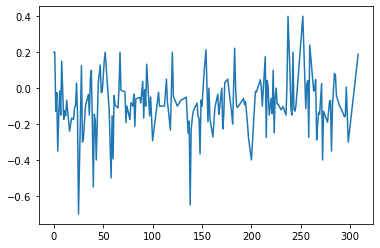

In [213]:
plt.plot(episodes_by_sent['episode'], episodes_by_sent['sentiment_avg'])

In [215]:
episodes_by_sent['cumulative'] = episodes_by_sent['sentiment_avg'].cumsum()

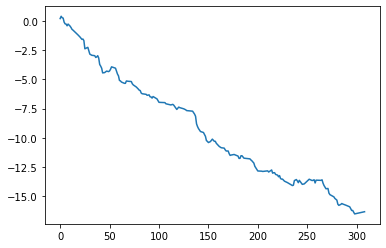

In [216]:
plt.plot(episodes_by_sent['episode'], episodes_by_sent['cumulative'])

<AxesSubplot:ylabel='Density'>

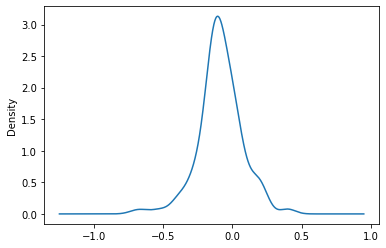

In [217]:
episodes_by_sent['sentiment_avg'].plot(kind = 'kde')

In [221]:
rolling_mean = episodes_by_sent['sentiment_avg'].rolling(window = 10).mean()

In [226]:
rolling_mean2 = episodes_by_sent['sentiment_avg'].rolling(window = 20).mean()

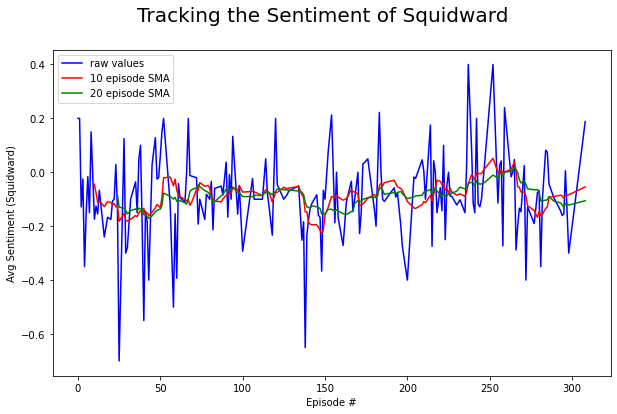

In [239]:
plt.figure(figsize = (10,6))
plt.suptitle('Tracking the Sentiment of Squidward', fontsize = 20)
plt.plot(episodes_by_sent.episode, episodes_by_sent.sentiment_avg, label = 'raw values', color = 'blue')
plt.plot(episodes_by_sent.episode, rolling_mean, label = '10 episode SMA', color = 'red')
plt.plot(episodes_by_sent.episode, rolling_mean2, label = '20 episode SMA', color = 'green')
plt.legend(loc = 'upper left')
plt.xlabel('Episode #')
plt.ylabel('Avg Sentiment (Squidward)')
plt.savefig("squidward_sentiment_graph.png")
plt.show()

In [242]:
episodes_by_sent.sentiment_avg.quantile([0.0, 0.25, 0.5, 0.75, 1.0])

0.000   -0.700
0.250   -0.155
0.500   -0.100
0.750    0.000
1.000    0.400
Name: sentiment_avg, dtype: float64

In [243]:
X = episodes_by_sent.sentiment_avg.values

In [246]:
split = round(len(X)/2)

In [247]:
X1, X2 = X[0:split], X[split:]

In [248]:
mean1, mean2 = X1.mean(), X2.mean()

In [249]:
var1, var2 = X1.var(), X2.var()

In [250]:
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=-0.103349, mean2=-0.069720
variance1=0.027091, variance2=0.022151


In [251]:
from statsmodels.tsa.stattools import adfuller

In [252]:
result = adfuller(X)

In [253]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values: ')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -12.439276
p-value: 0.000000
Critical Values: 
	1%: -3.466
	5%: -2.877
	10%: -2.575
